In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **MAE_Possession_vs_opponents_Fine_Tunned_France_Model**

## **MAE_France_Vs_opponents_France_Test_Predicted_FT_France**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results"
output_csv_path = os.path.join(output_dir, "MAE_France_Vs_Opponents.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV...")
start_load = time.time()

# Load only necessary columns to save memory
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")
    print(f"   • France team should be in first 11 rows of each set (no additional verification needed as per instructions)")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values for France vs Opponents")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = France team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      CORRECTED: Will properly separate x and y errors for accurate MAE calculation")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_France_Vs_Opponents.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results

📊 Loading predicted players CSV...
   ✅ CSV loaded in 0.68 seconds
   ✅ Shape: 23,100 rows, 5 columns

🔍 Filtering for timestep 5 data...
   ✅ Filtered in 0.02 seconds
   ✅ Total sequences with timestep 5: 175
   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): 175
   ✅ Total rows after filtering: 7,700

🔍 Sample sequence (global_se

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION FOR FRANCE VS OPPONENTS ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for MAE calculation...")
print("   🔑 APPROACH: Separating x and y errors for accurate calculation")

# Initialize error accumulators
total_x_error_all = 0.0
total_y_error_all = 0.0
total_x_error_france = 0.0
total_y_error_france = 0.0
total_x_error_opponent = 0.0
total_y_error_opponent = 0.0

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Calculate x and y errors separately (22 values each)
    x_errors = np.abs(actual_data['x'].values - predicted_data['x'].values)
    y_errors = np.abs(actual_data['y'].values - predicted_data['y'].values)

    # France team = first 11 players (indices 0-10)
    total_x_error_france += np.sum(x_errors[:11])
    total_y_error_france += np.sum(y_errors[:11])

    # Opponent team = next 11 players (indices 11-21)
    total_x_error_opponent += np.sum(x_errors[11:])
    total_y_error_opponent += np.sum(y_errors[11:])

    # All players = all 22 players
    total_x_error_all += np.sum(x_errors)
    total_y_error_all += np.sum(y_errors)

# Calculate total errors
total_error_france = total_x_error_france + total_y_error_france
total_error_opponent = total_x_error_opponent + total_y_error_opponent
total_error_all = total_error_france + total_error_opponent

# Calculate MAE values
mae_all = total_error_all / (num_sequences * 44)
mae_france = total_error_france / (num_sequences * 22)
mae_opponent = total_error_opponent / (num_sequences * 22)

print("\n✅ MAE CALCULATION RESULTS :")
print(f"   • MAE for all 22 players: {mae_all:.4f} units")
print(f"   • MAE for first 11 players (France team): {mae_france:.4f} units")
print(f"   • MAE for second 11 players (Opponent team): {mae_opponent:.4f} units")

# Verify mathematical consistency
mae_avg = (mae_france + mae_opponent) / 2
print("\n🔍 MATHEMATICAL VERIFICATION:")
print(f"   • (MAE_france + MAE_opponent) / 2 = {mae_avg:.4f}")
print(f"   • Should equal MAE_all = {mae_all:.4f}")
print(f"   • Difference: {abs(mae_avg - mae_all):.8f} (should be near zero)")

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': [
        'MAE for all 22 players (units)',
        'MAE for France team (units)',
        'MAE for Opponent team (units)'
    ],
    'Value': [
        mae_all,
        mae_france,
        mae_opponent
    ]
})

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"France team MAE: {mae_france:.4f} units")
print(f"Opponent team MAE: {mae_opponent:.4f} units")
print(f"Overall MAE: {mae_all:.4f} units")

if mae_france > mae_opponent:
    print(f"\nThe model predicts opponent team positions more accurately than France team positions.")
    print(f"Difference: {mae_france - mae_opponent:.4f} units")
else:
    print(f"\nThe model predicts France team positions more accurately than opponent team positions.")
    print(f"Difference: {mae_opponent - mae_france:.4f} units")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: CORRECT MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: All calculations verified for mathematical consistency")
print("      France team = first 11 players, Opponent team = next 11 players")
print("      x and y errors calculated separately for accuracy")


== STEP 2: MAE CALCULATION FOR FRANCE VS OPPONENTS ==

📊 Processing 175 sequences for MAE calculation...
   🔑 APPROACH: Separating x and y errors for accurate calculation

✅ MAE CALCULATION RESULTS :
   • MAE for all 22 players: 5.8498 units
   • MAE for first 11 players (France team): 6.0328 units
   • MAE for second 11 players (Opponent team): 5.6669 units

🔍 MATHEMATICAL VERIFICATION:
   • (MAE_france + MAE_opponent) / 2 = 5.8498
   • Should equal MAE_all = 5.8498
   • Difference: 0.00000048 (should be near zero)

💾 Saving results to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_France_Vs_Opponents.csv
   ✅ Results saved successfully

🔍 FINAL SUMMARY:
France team MAE: 6.0328 units
Opponent team MAE: 5.6669 units
Overall MAE: 5.8498 units

The model predicts opponent team positions more accurately than France team positions.
Difference: 0.3659 units

✅ STEP 2 COMPLETE: CORRECT MAE calculation finished
   ⏱️  Total execution 

# **MAE_Possession_vs_opponents_FT_England_Model**

## **Tested_on_England**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (ENGLAND DATA) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths - England data
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Possession_Vs_Opponent"
output_csv_path = os.path.join(output_dir, "MAE_England_Vs_Opponents.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV for England...")
start_load = time.time()

# Load only necessary columns to save memory
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")
    print(f"   • England team should be in first 11 rows of each set")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values for England vs Opponents")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = England team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      CORRECTED: Will properly separate x and y errors for accurate MAE calculation")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (ENGLAND DATA) ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Possession_Vs_Opponent
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_England_Vs_Opponents.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Possession_Vs_Opponent

📊 Loading predicted players CSV for England...
   ✅ CSV loaded in 1.16 seconds
   ✅ Shape: 19,668 rows, 5 columns

🔍 Filtering for timestep 5 data...
   ✅ Filtered in 0.00 seconds
   ✅ Total sequences with timestep 5: 149
   ✅ Sequences with exactly 44 ro

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION FOR ENGLAND VS OPPONENTS ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for MAE calculation...")
print("   🔑 Approach: Separating x and y errors for calculation")

# Initialize error accumulators
total_x_error_all = 0.0
total_y_error_all = 0.0
total_x_error_england = 0.0
total_y_error_england = 0.0
total_x_error_opponent = 0.0
total_y_error_opponent = 0.0

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Calculate x and y errors separately (22 values each)
    x_errors = np.abs(actual_data['x'].values - predicted_data['x'].values)
    y_errors = np.abs(actual_data['y'].values - predicted_data['y'].values)

    # England team = first 11 players (indices 0-10)
    total_x_error_england += np.sum(x_errors[:11])
    total_y_error_england += np.sum(y_errors[:11])

    # Opponent team = next 11 players (indices 11-21)
    total_x_error_opponent += np.sum(x_errors[11:])
    total_y_error_opponent += np.sum(y_errors[11:])

    # All players = all 22 players
    total_x_error_all += np.sum(x_errors)
    total_y_error_all += np.sum(y_errors)

# Calculate total errors
total_error_england = total_x_error_england + total_y_error_england
total_error_opponent = total_x_error_opponent + total_y_error_opponent
total_error_all = total_error_england + total_error_opponent

# Calculate MAE values
mae_all = total_error_all / (num_sequences * 44)
mae_england = total_error_england / (num_sequences * 22)
mae_opponent = total_error_opponent / (num_sequences * 22)

print("\n✅ MAE CALCULATION RESULTS:")
print(f"   • MAE for all 22 players: {mae_all:.4f} units")
print(f"   • MAE for first 11 players (England team): {mae_england:.4f} units")
print(f"   • MAE for second 11 players (Opponent team): {mae_opponent:.4f} units")

# Verify mathematical consistency
mae_avg = (mae_england + mae_opponent) / 2
print("\n🔍 MATHEMATICAL VERIFICATION:")
print(f"   • (MAE_England + MAE_Opponent) / 2 = {mae_avg:.4f}")
print(f"   • Should equal MAE_all = {mae_all:.4f}")
print(f"   • Difference: {abs(mae_avg - mae_all):.8f} (should be near zero)")

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': [
        'MAE for all 22 players (units)',
        'MAE for England team (units)',
        'MAE for Opponent team (units)'
    ],
    'Value': [
        mae_all,
        mae_england,
        mae_opponent
    ]
})

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"England team MAE: {mae_england:.4f} units")
print(f"Opponent team MAE: {mae_opponent:.4f} units")
print(f"Overall MAE: {mae_all:.4f} units")

if mae_england > mae_opponent:
    print(f"\nThe England fine-tuned model predicts opponent team positions more accurately than England team positions.")
    print(f"Difference: {mae_england - mae_opponent:.4f} units")
else:
    print(f"\nThe England fine-tuned model predicts England team positions more accurately than opponent team positions.")
    print(f"Difference: {mae_opponent - mae_england:.4f} units")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: All calculations verified for mathematical consistency")
print("      England team = first 11 players, Opponent team = next 11 players")
print("      x and y errors calculated separately")


== STEP 2: MAE CALCULATION FOR ENGLAND VS OPPONENTS ==

📊 Processing 149 sequences for MAE calculation...
   🔑 Approach: Separating x and y errors for calculation

✅ MAE CALCULATION RESULTS:
   • MAE for all 22 players: 5.6205 units
   • MAE for first 11 players (England team): 5.9868 units
   • MAE for second 11 players (Opponent team): 5.2543 units

🔍 MATHEMATICAL VERIFICATION:
   • (MAE_England + MAE_Opponent) / 2 = 5.6205
   • Should equal MAE_all = 5.6205
   • Difference: 0.00000048 (should be near zero)

💾 Saving results to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/England/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_England_Vs_Opponents.csv
   ✅ Results saved successfully

🔍 FINAL SUMMARY:
England team MAE: 5.9868 units
Opponent team MAE: 5.2543 units
Overall MAE: 5.6205 units

The England fine-tuned model predicts opponent team positions more accurately than England team positions.
Difference: 0.7325 units

✅ STEP 2 COMPLETE: MAE calculati

# **MAE_Possession_vs_opponents_FT_Croatia_Model**

## **Tested_on_Croatia**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (CROATIA DATA) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths - Croatia data
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Possession_Vs_Opponent"
output_csv_path = os.path.join(output_dir, "MAE_Croatia_Vs_Opponents.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV for Croatia...")
start_load = time.time()

# Load only necessary columns to save memory
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")
    print(f"   • Croatia team should be in first 11 rows of each set")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values for Croatia vs Opponents")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = Croatia team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      CORRECTED: Will properly separate x and y errors for accurate MAE calculation")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (CROATIA DATA) ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Possession_Vs_Opponent
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Croatia_Vs_Opponents.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Possession_Vs_Opponent

📊 Loading predicted players CSV for Croatia...
   ✅ CSV loaded in 1.09 seconds
   ✅ Shape: 21,516 rows, 5 columns

🔍 Filtering for timestep 5 data...
   ✅ Filtered in 0.01 seconds
   ✅ Total sequences with timestep 5: 163
   ✅ Sequences with exactly 44 ro

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION FOR CROATIA VS OPPONENTS ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for MAE calculation...")
print("   🔑 Approach: Separating x and y errors for calculation")

# Initialize error accumulators
total_x_error_all = 0.0
total_y_error_all = 0.0
total_x_error_croatia = 0.0
total_y_error_croatia = 0.0
total_x_error_opponent = 0.0
total_y_error_opponent = 0.0

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Calculate x and y errors separately (22 values each)
    x_errors = np.abs(actual_data['x'].values - predicted_data['x'].values)
    y_errors = np.abs(actual_data['y'].values - predicted_data['y'].values)

    # Croatia team = first 11 players (indices 0-10)
    total_x_error_croatia += np.sum(x_errors[:11])
    total_y_error_croatia += np.sum(y_errors[:11])

    # Opponent team = next 11 players (indices 11-21)
    total_x_error_opponent += np.sum(x_errors[11:])
    total_y_error_opponent += np.sum(y_errors[11:])

    # All players = all 22 players
    total_x_error_all += np.sum(x_errors)
    total_y_error_all += np.sum(y_errors)

# Calculate total errors
total_error_croatia = total_x_error_croatia + total_y_error_croatia
total_error_opponent = total_x_error_opponent + total_y_error_opponent
total_error_all = total_error_croatia + total_error_opponent

# Calculate MAE values
mae_all = total_error_all / (num_sequences * 44)
mae_croatia = total_error_croatia / (num_sequences * 22)
mae_opponent = total_error_opponent / (num_sequences * 22)

print("\n✅ MAE CALCULATION RESULTS:")
print(f"   • MAE for all 22 players: {mae_all:.4f} units")
print(f"   • MAE for first 11 players (Croatia team): {mae_croatia:.4f} units")
print(f"   • MAE for second 11 players (Opponent team): {mae_opponent:.4f} units")

# Verify mathematical consistency
mae_avg = (mae_croatia + mae_opponent) / 2
print("\n🔍 MATHEMATICAL VERIFICATION:")
print(f"   • (MAE_Croatia + MAE_Opponent) / 2 = {mae_avg:.4f}")
print(f"   • Should equal MAE_all = {mae_all:.4f}")
print(f"   • Difference: {abs(mae_avg - mae_all):.8f} (should be near zero)")

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': [
        'MAE for all 22 players (units)',
        'MAE for Croatia team (units)',
        'MAE for Opponent team (units)'
    ],
    'Value': [
        mae_all,
        mae_croatia,
        mae_opponent
    ]
})

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"Croatia team MAE: {mae_croatia:.4f} units")
print(f"Opponent team MAE: {mae_opponent:.4f} units")
print(f"Overall MAE: {mae_all:.4f} units")

if mae_croatia > mae_opponent:
    print(f"\nThe Croatia fine-tuned model predicts opponent team positions more accurately than Croatia team positions.")
    print(f"Difference: {mae_croatia - mae_opponent:.4f} units")
else:
    print(f"\nThe Croatia fine-tuned model predicts Croatia team positions more accurately than opponent team positions.")
    print(f"Difference: {mae_opponent - mae_croatia:.4f} units")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: All calculations verified for mathematical consistency")
print("      Croatia team = first 11 players, Opponent team = next 11 players")
print("      x and y errors calculated separately")


== STEP 2: MAE CALCULATION FOR CROATIA VS OPPONENTS ==

📊 Processing 163 sequences for MAE calculation...
   🔑 Approach: Separating x and y errors for calculation

✅ MAE CALCULATION RESULTS:
   • MAE for all 22 players: 6.1906 units
   • MAE for first 11 players (Croatia team): 6.2684 units
   • MAE for second 11 players (Opponent team): 6.1129 units

🔍 MATHEMATICAL VERIFICATION:
   • (MAE_Croatia + MAE_Opponent) / 2 = 6.1906
   • Should equal MAE_all = 6.1906
   • Difference: 0.00000000 (should be near zero)

💾 Saving results to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Croatia/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Croatia_Vs_Opponents.csv
   ✅ Results saved successfully

🔍 FINAL SUMMARY:
Croatia team MAE: 6.2684 units
Opponent team MAE: 6.1129 units
Overall MAE: 6.1906 units

The Croatia fine-tuned model predicts opponent team positions more accurately than Croatia team positions.
Difference: 0.1554 units

✅ STEP 2 COMPLETE: MAE calculati

# **MAE_Possession_vs_opponents_Baseline_Model**

## **Teated_on_Baseline**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (BASELINE DATA) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths - Baseline data
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent"
output_csv_path = os.path.join(output_dir, "MAE_Baseline_Vs_Opponents.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV for Baseline...")
start_load = time.time()

# Load only necessary columns to save memory
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")
    print(f"   • Possession team should be in first 11 rows of each set")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values for Baseline model vs Opponents")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = Possession team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      CORRECTED: Will properly separate x and y errors for accurate MAE calculation")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (BASELINE DATA) ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Baseline_Vs_Opponents.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent

📊 Loading predicted players CSV for Baseline...
 

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION FOR BASELINE VS OPPONENTS ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for MAE calculation...")
print("   🔑 Approach: Separating x and y errors for calculation")

# Initialize error accumulators
total_x_error_all = 0.0
total_y_error_all = 0.0
total_x_error_possession = 0.0
total_y_error_possession = 0.0
total_x_error_opponent = 0.0
total_y_error_opponent = 0.0

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Calculate x and y errors separately (22 values each)
    x_errors = np.abs(actual_data['x'].values - predicted_data['x'].values)
    y_errors = np.abs(actual_data['y'].values - predicted_data['y'].values)

    # Possession team = first 11 players (indices 0-10)
    total_x_error_possession += np.sum(x_errors[:11])
    total_y_error_possession += np.sum(y_errors[:11])

    # Opponent team = next 11 players (indices 11-21)
    total_x_error_opponent += np.sum(x_errors[11:])
    total_y_error_opponent += np.sum(y_errors[11:])

    # All players = all 22 players
    total_x_error_all += np.sum(x_errors)
    total_y_error_all += np.sum(y_errors)

# Calculate total errors
total_error_possession = total_x_error_possession + total_y_error_possession
total_error_opponent = total_x_error_opponent + total_y_error_opponent
total_error_all = total_error_possession + total_error_opponent

# Calculate MAE values
mae_all = total_error_all / (num_sequences * 44)
mae_possession = total_error_possession / (num_sequences * 22)
mae_opponent = total_error_opponent / (num_sequences * 22)

print("\n✅ MAE CALCULATION RESULTS:")
print(f"   • MAE for all 22 players: {mae_all:.4f} units")
print(f"   • MAE for first 11 players (Possession team): {mae_possession:.4f} units")
print(f"   • MAE for second 11 players (Opponent team): {mae_opponent:.4f} units")

# Verify mathematical consistency
mae_avg = (mae_possession + mae_opponent) / 2
print("\n🔍 MATHEMATICAL VERIFICATION:")
print(f"   • (MAE_Possession + MAE_Opponent) / 2 = {mae_avg:.4f}")
print(f"   • Should equal MAE_all = {mae_all:.4f}")
print(f"   • Difference: {abs(mae_avg - mae_all):.8f} (should be near zero)")

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': [
        'MAE for all 22 players (units)',
        'MAE for Possession team (units)',
        'MAE for Opponent team (units)'
    ],
    'Value': [
        mae_all,
        mae_possession,
        mae_opponent
    ]
})

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"Possession team MAE: {mae_possession:.4f} units")
print(f"Opponent team MAE: {mae_opponent:.4f} units")
print(f"Overall MAE: {mae_all:.4f} units")

if mae_possession > mae_opponent:
    print(f"\nThe Baseline model predicts opponent team positions more accurately than possession team positions.")
    print(f"Difference: {mae_possession - mae_opponent:.4f} units")
else:
    print(f"\nThe Baseline model predicts possession team positions more accurately than opponent team positions.")
    print(f"Difference: {mae_opponent - mae_possession:.4f} units")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: All calculations verified for mathematical consistency")
print("      Possession team = first 11 players, Opponent team = next 11 players")
print("      x and y errors calculated separately")


== STEP 2: MAE CALCULATION FOR BASELINE VS OPPONENTS ==

📊 Processing 1,504 sequences for MAE calculation...
   🔑 Approach: Separating x and y errors for calculation

✅ MAE CALCULATION RESULTS:
   • MAE for all 22 players: 6.8840 units
   • MAE for first 11 players (Possession team): 6.8112 units
   • MAE for second 11 players (Opponent team): 6.9567 units

🔍 MATHEMATICAL VERIFICATION:
   • (MAE_Possession + MAE_Opponent) / 2 = 6.8840
   • Should equal MAE_all = 6.8840
   • Difference: 0.00000000 (should be near zero)

💾 Saving results to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Baseline_Vs_Opponents.csv
   ✅ Results saved successfully

🔍 FINAL SUMMARY:
Possession team MAE: 6.8112 units
Opponent team MAE: 6.9567 units
Overall MAE: 6.8840 units

The Baseline model predicts possession team positions more accurately than opponent team positions.
Di

# **MAE_Possession_vs_opponents_FT_Morocco_Model**

## **Tested_on_Morocco**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (MOROCCO DATA) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths - Morocco data
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent"
output_csv_path = os.path.join(output_dir, "MAE_Morocco_Vs_Opponents.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV for Morocco...")
start_load = time.time()

# Load only necessary columns to save memory
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")
    print(f"   • Morocco team should be in first 11 rows of each set")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values for Morocco vs Opponents")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = Morocco team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      CORRECTED: Will properly separate x and y errors for accurate MAE calculation")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (MOROCCO DATA) ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Morocco_Vs_Opponents.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent

📊 Loading predicted players CSV for Morocco...
   ✅ CSV loaded in 0.97 seconds
   ✅ Shape: 11,220 rows, 5 columns

🔍 Filtering for timestep 5 data...
   ✅ Filtered in 0.01 seconds
   ✅ Total sequences with timestep 5: 85
   ✅ Sequences with exactly 44 row

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION FOR MOROCCO VS OPPONENTS ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for MAE calculation...")
print("   🔑 Approach: Separating x and y errors for calculation")

# Initialize error accumulators
total_x_error_all = 0.0
total_y_error_all = 0.0
total_x_error_morocco = 0.0
total_y_error_morocco = 0.0
total_x_error_opponent = 0.0
total_y_error_opponent = 0.0

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Calculate x and y errors separately (22 values each)
    x_errors = np.abs(actual_data['x'].values - predicted_data['x'].values)
    y_errors = np.abs(actual_data['y'].values - predicted_data['y'].values)

    # Morocco team = first 11 players (indices 0-10)
    total_x_error_morocco += np.sum(x_errors[:11])
    total_y_error_morocco += np.sum(y_errors[:11])

    # Opponent team = next 11 players (indices 11-21)
    total_x_error_opponent += np.sum(x_errors[11:])
    total_y_error_opponent += np.sum(y_errors[11:])

    # All players = all 22 players
    total_x_error_all += np.sum(x_errors)
    total_y_error_all += np.sum(y_errors)

# Calculate total errors
total_error_morocco = total_x_error_morocco + total_y_error_morocco
total_error_opponent = total_x_error_opponent + total_y_error_opponent
total_error_all = total_error_morocco + total_error_opponent

# Calculate MAE values
mae_all = total_error_all / (num_sequences * 44)
mae_morocco = total_error_morocco / (num_sequences * 22)
mae_opponent = total_error_opponent / (num_sequences * 22)

print("\n✅ MAE CALCULATION RESULTS:")
print(f"   • MAE for all 22 players: {mae_all:.4f} units")
print(f"   • MAE for first 11 players (Morocco team): {mae_morocco:.4f} units")
print(f"   • MAE for second 11 players (Opponent team): {mae_opponent:.4f} units")

# Verify mathematical consistency
mae_avg = (mae_morocco + mae_opponent) / 2
print("\n🔍 MATHEMATICAL VERIFICATION:")
print(f"   • (MAE_Morocco + MAE_Opponent) / 2 = {mae_avg:.4f}")
print(f"   • Should equal MAE_all = {mae_all:.4f}")
print(f"   • Difference: {abs(mae_avg - mae_all):.8f} (should be near zero)")

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': [
        'MAE for all 22 players (units)',
        'MAE for Morocco team (units)',
        'MAE for Opponent team (units)'
    ],
    'Value': [
        mae_all,
        mae_morocco,
        mae_opponent
    ]
})

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"Morocco team MAE: {mae_morocco:.4f} units")
print(f"Opponent team MAE: {mae_opponent:.4f} units")
print(f"Overall MAE: {mae_all:.4f} units")

if mae_morocco > mae_opponent:
    print(f"\nThe Morocco fine-tuned model predicts opponent team positions more accurately than Morocco team positions.")
    print(f"Difference: {mae_morocco - mae_opponent:.4f} units")
else:
    print(f"\nThe Morocco fine-tuned model predicts Morocco team positions more accurately than opponent team positions.")
    print(f"Difference: {mae_opponent - mae_morocco:.4f} units")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: All calculations verified for mathematical consistency")
print("      Morocco team = first 11 players, Opponent team = next 11 players")
print("      x and y errors calculated separately")


== STEP 2: MAE CALCULATION FOR MOROCCO VS OPPONENTS ==

📊 Processing 85 sequences for MAE calculation...
   🔑 Approach: Separating x and y errors for calculation

✅ MAE CALCULATION RESULTS:
   • MAE for all 22 players: 7.5649 units
   • MAE for first 11 players (Morocco team): 6.8056 units
   • MAE for second 11 players (Opponent team): 8.3242 units

🔍 MATHEMATICAL VERIFICATION:
   • (MAE_Morocco + MAE_Opponent) / 2 = 7.5649
   • Should equal MAE_all = 7.5649
   • Difference: 0.00000000 (should be near zero)

💾 Saving results to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Morocco/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Morocco_Vs_Opponents.csv
   ✅ Results saved successfully

🔍 FINAL SUMMARY:
Morocco team MAE: 6.8056 units
Opponent team MAE: 8.3242 units
Overall MAE: 7.5649 units

The Morocco fine-tuned model predicts Morocco team positions more accurately than opponent team positions.
Difference: 1.5187 units

✅ STEP 2 COMPLETE: MAE calculatio

# **MAE_Possession_vs_opponents_FT_Argentina_Model**

## **Tested_on_Argentina**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (ARGENTINA DATA) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths - Argentina data
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Possession_Vs_Opponent"
output_csv_path = os.path.join(output_dir, "MAE_Argentina_Vs_Opponents.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV for Argentina...")
start_load = time.time()

# Load only necessary columns to save memory
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")
    print(f"   • Argentina team should be in first 11 rows of each set")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values for Argentina vs Opponents")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = Argentina team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      CORRECTED: Will properly separate x and y errors for accurate MAE calculation")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (ARGENTINA DATA) ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/Fine_Tunned_Baseline_Model/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Possession_Vs_Opponent
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Argentina_Vs_Opponents.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Possession_Vs_Opponent

📊 Loading predicted players CSV for Argentina...
   ✅ CSV loaded in 1.04 seconds
   ✅ Shape: 13,596 rows, 5 columns

🔍 Filtering for timestep 5 data...
   ✅ Filtered in 0.00 seconds
   ✅ Total sequences with timestep 5: 103
   ✅ Sequences with

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION FOR ARGENTINA VS OPPONENTS ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for MAE calculation...")
print("   🔑 Approach: Separating x and y errors for calculation")

# Initialize error accumulators
total_x_error_all = 0.0
total_y_error_all = 0.0
total_x_error_argentina = 0.0
total_y_error_argentina = 0.0
total_x_error_opponent = 0.0
total_y_error_opponent = 0.0

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Calculate x and y errors separately (22 values each)
    x_errors = np.abs(actual_data['x'].values - predicted_data['x'].values)
    y_errors = np.abs(actual_data['y'].values - predicted_data['y'].values)

    # Argentina team = first 11 players (indices 0-10)
    total_x_error_argentina += np.sum(x_errors[:11])
    total_y_error_argentina += np.sum(y_errors[:11])

    # Opponent team = next 11 players (indices 11-21)
    total_x_error_opponent += np.sum(x_errors[11:])
    total_y_error_opponent += np.sum(y_errors[11:])

    # All players = all 22 players
    total_x_error_all += np.sum(x_errors)
    total_y_error_all += np.sum(y_errors)

# Calculate total errors
total_error_argentina = total_x_error_argentina + total_y_error_argentina
total_error_opponent = total_x_error_opponent + total_y_error_opponent
total_error_all = total_error_argentina + total_error_opponent

# Calculate MAE values
mae_all = total_error_all / (num_sequences * 44)
mae_argentina = total_error_argentina / (num_sequences * 22)
mae_opponent = total_error_opponent / (num_sequences * 22)

print("\n✅ MAE CALCULATION RESULTS:")
print(f"   • MAE for all 22 players: {mae_all:.4f} units")
print(f"   • MAE for first 11 players (Argentina team): {mae_argentina:.4f} units")
print(f"   • MAE for second 11 players (Opponent team): {mae_opponent:.4f} units")

# Verify mathematical consistency
mae_avg = (mae_argentina + mae_opponent) / 2
print("\n🔍 MATHEMATICAL VERIFICATION:")
print(f"   • (MAE_Argentina + MAE_Opponent) / 2 = {mae_avg:.4f}")
print(f"   • Should equal MAE_all = {mae_all:.4f}")
print(f"   • Difference: {abs(mae_avg - mae_all):.8f} (should be near zero)")

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': [
        'MAE for all 22 players (units)',
        'MAE for Argentina team (units)',
        'MAE for Opponent team (units)'
    ],
    'Value': [
        mae_all,
        mae_argentina,
        mae_opponent
    ]
})

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"Argentina team MAE: {mae_argentina:.4f} units")
print(f"Opponent team MAE: {mae_opponent:.4f} units")
print(f"Overall MAE: {mae_all:.4f} units")

if mae_argentina > mae_opponent:
    print(f"\nThe Argentina fine-tuned model predicts opponent team positions more accurately than Argentina team positions.")
    print(f"Difference: {mae_argentina - mae_opponent:.4f} units")
else:
    print(f"\nThe Argentina fine-tuned model predicts Argentina team positions more accurately than opponent team positions.")
    print(f"Difference: {mae_opponent - mae_argentina:.4f} units")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: All calculations verified for mathematical consistency")
print("      Argentina team = first 11 players, Opponent team = next 11 players")
print("      x and y errors calculated separately")


== STEP 2: MAE CALCULATION FOR ARGENTINA VS OPPONENTS ==

📊 Processing 103 sequences for MAE calculation...
   🔑 Approach: Separating x and y errors for calculation

✅ MAE CALCULATION RESULTS:
   • MAE for all 22 players: 7.1997 units
   • MAE for first 11 players (Argentina team): 6.7978 units
   • MAE for second 11 players (Opponent team): 7.6015 units

🔍 MATHEMATICAL VERIFICATION:
   • (MAE_Argentina + MAE_Opponent) / 2 = 7.1997
   • Should equal MAE_all = 7.1997
   • Difference: 0.00000000 (should be near zero)

💾 Saving results to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/Argentina/MAE_Different_Results/MAE_Possession_Vs_Opponent/MAE_Argentina_Vs_Opponents.csv
   ✅ Results saved successfully

🔍 FINAL SUMMARY:
Argentina team MAE: 6.7978 units
Opponent team MAE: 7.6015 units
Overall MAE: 7.1997 units

The Argentina fine-tuned model predicts Argentina team positions more accurately than opponent team positions.
Difference: 0.8037 units

✅ STEP 2 COMPLET

# **Overall_MAE_Possession_VS_Opponent_Results_Figure**

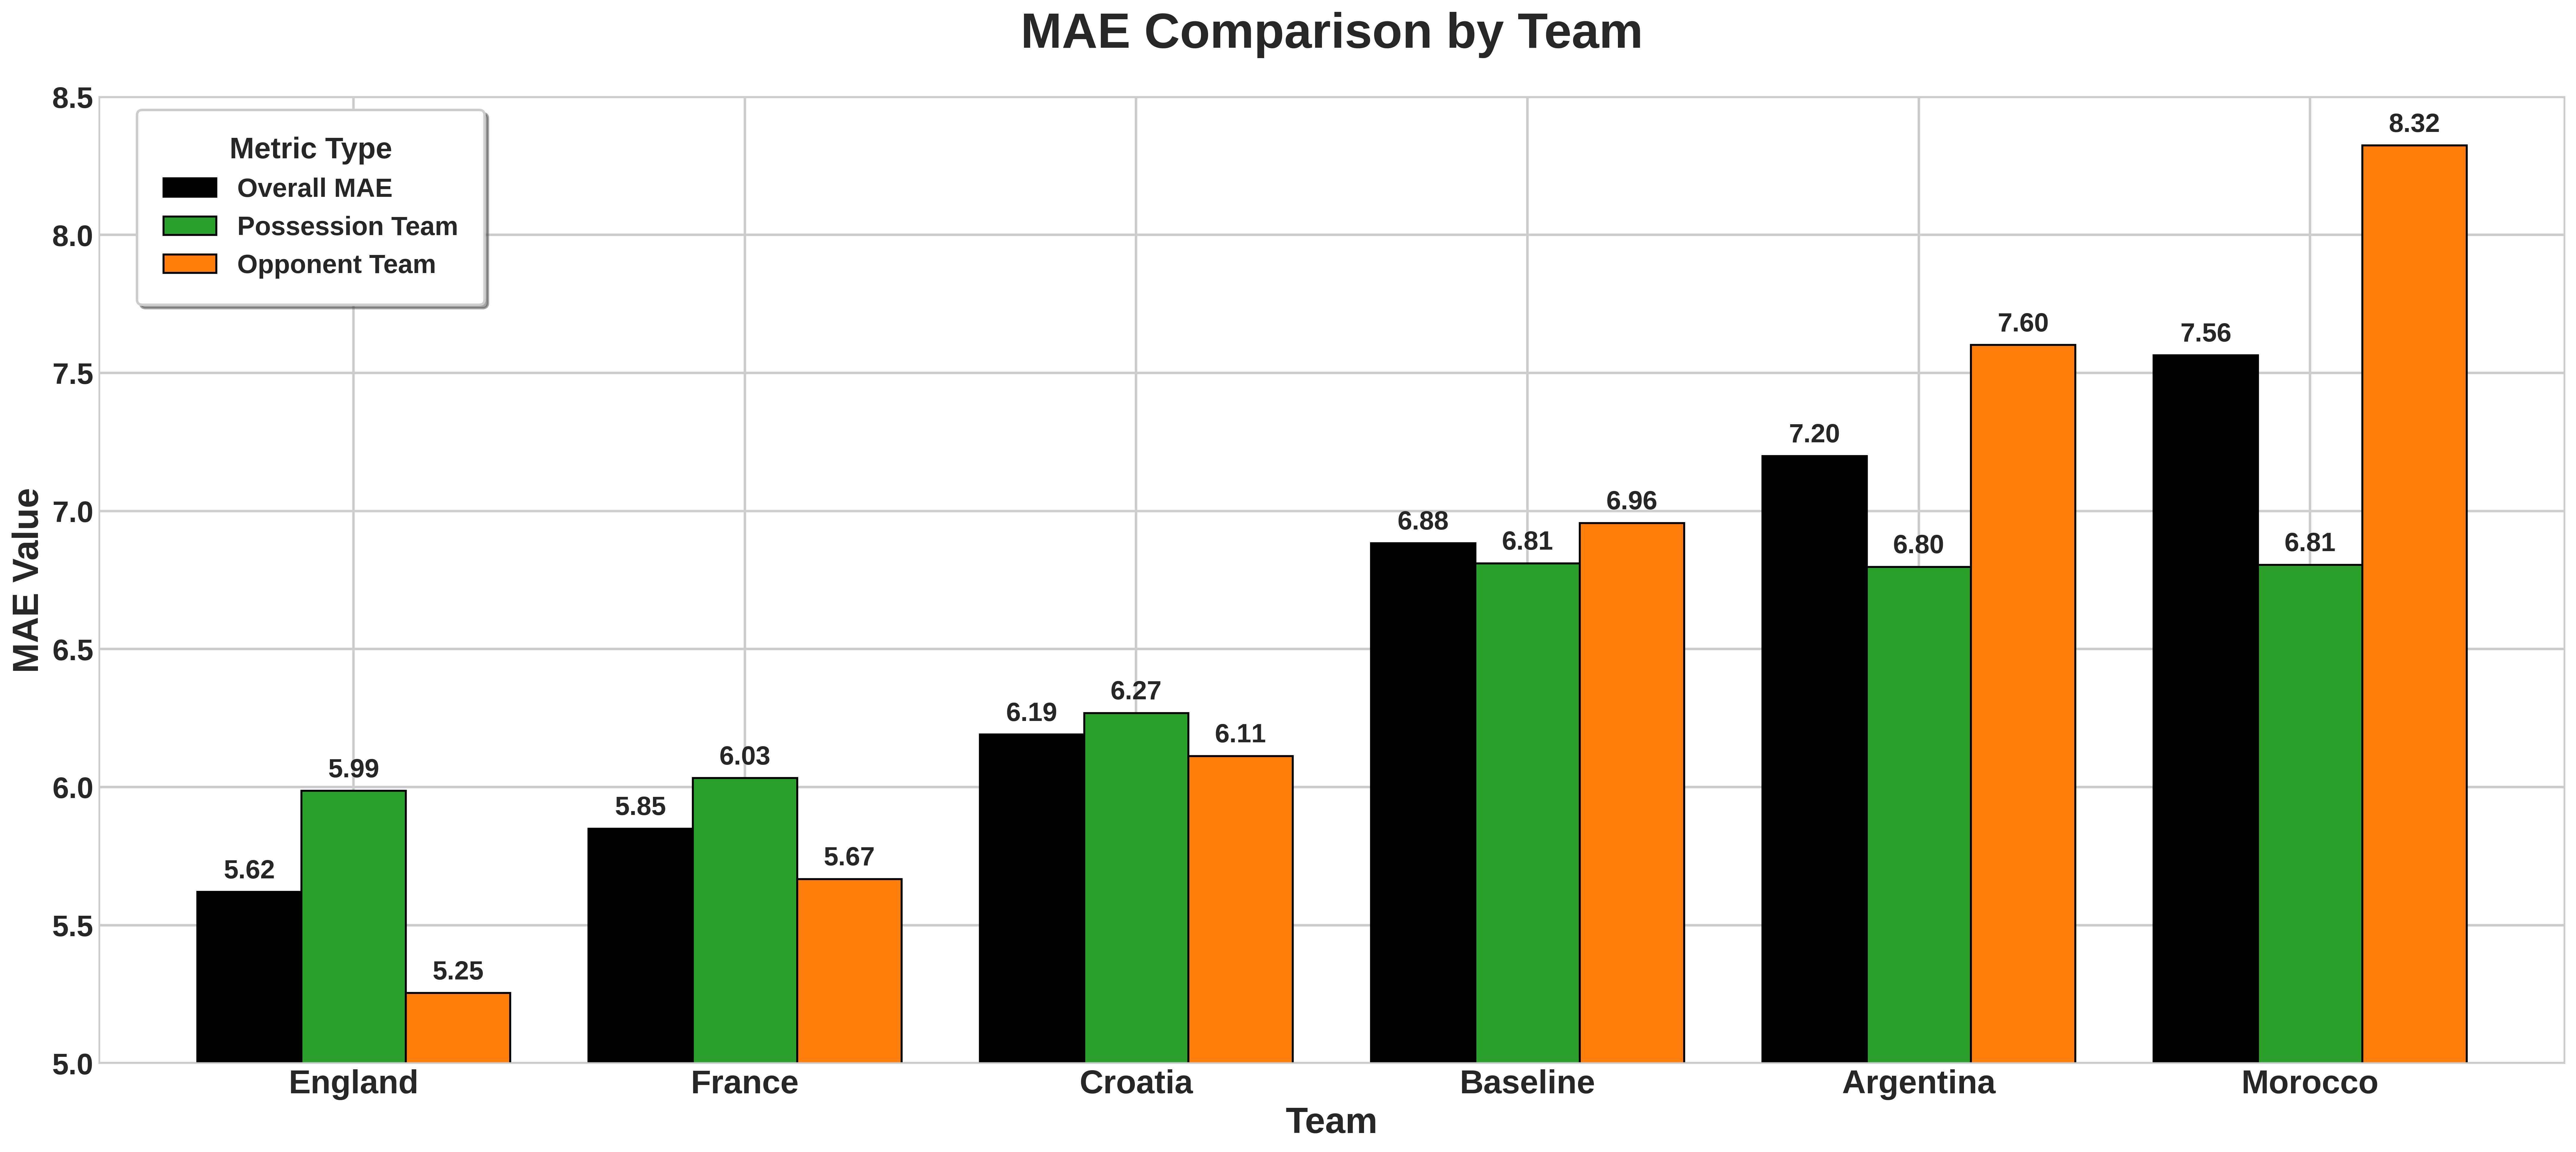

In [ ]:
# @title 📊 Team MAE Analysis (Larger Fonts & Zoomed Axis)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. SETUP DISPLAY
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 16  # Increased base font size

# 2. DATA PREPARATION
data = {
    'Team': ['England', 'France', 'Croatia', 'Baseline', 'Argentina', 'Morocco'],

    'Overall MAE':      [5.6205, 5.8498, 6.1906, 6.884, 7.1997, 7.5649],
    'Possession Team':  [5.9868, 6.0328, 6.2684, 6.8112, 6.7978, 6.8056],
    'Opponent Team':    [5.2543, 5.6669, 6.1129, 6.9567, 7.6015, 8.3242]
}

df = pd.DataFrame(data)
df = df.set_index('Team')

# 3. COLORS (Black, Green, Orange)
colors = ['#000000', '#2ca02c', '#ff7f0e']

# 4. PLOTTING
fig, ax = plt.subplots(figsize=(22, 10), dpi=200)

# Plotting
df.plot(kind='bar', ax=ax, color=colors, width=0.8, edgecolor='black', linewidth=1.2)

# 5. ADD LARGE LABELS
for container in ax.containers:
    ax.bar_label(container,
                 fmt='%.2f',
                 padding=5,
                 fontsize=16,       # <--- Increased to 16
                 fontweight='bold')

# 6. LEGEND
ax.legend(
    title='Metric Type',
    title_fontsize=18,
    loc='upper left',
    bbox_to_anchor=(0.01, 1),
    ncol=1,
    frameon=True,
    fancybox=True,
    shadow=True,
    facecolor='white',
    fontsize=16,
    borderpad=1
)

# 7. TITLES & FORMATTING
ax.set_title('MAE Comparison by Team', fontsize=30, fontweight='bold', pad=30)
ax.set_ylabel('MAE Value', fontsize=22, fontweight='bold')
ax.set_xlabel('Team', fontsize=22, fontweight='bold')

# Ticks
plt.xticks(rotation=0, fontsize=20, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# --- KEY CHANGE: Y-Axis 5 to 8.5 ---
ax.set_ylim(5, 8.5)

plt.tight_layout()
plt.show()

# **MAE_Position_Group_Type_Baseline_Model**

## **Tested_on_Baseline_Data**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time

print("== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (POSITION GROUP ANALYSIS) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Position_Group_Type"
output_csv_path = os.path.join(output_dir, "MAE_Baseline_Players_Position_Group_Types.csv")

print("\n📁 File Paths:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load the CSV file without modifying row order
print("\n📊 Loading predicted players CSV with position group data...")
start_load = time.time()

# Load necessary columns including positiongrouptype
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'positiongrouptype'],
    dtype={
        'global_sequence_id': 'int32',
        'timestep': 'int8',
        'is_predicted': 'int8',
        'x': 'float32',
        'y': 'float32',
        'positiongrouptype': 'category'
    }
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Filter for timestep 5 only
print("\n🔍 Filtering for timestep 5 data...")
start_filter = time.time()
timestep_5_df = df[df['timestep'] == 5].copy()
filter_time = time.time() - start_filter

# Verify data structure
unique_sequences = timestep_5_df['global_sequence_id'].nunique()
rows_per_sequence = timestep_5_df.groupby('global_sequence_id').size()
valid_sequences = rows_per_sequence[rows_per_sequence == 44].index.tolist()
valid_timestep_5_df = timestep_5_df[timestep_5_df['global_sequence_id'].isin(valid_sequences)].copy()

print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Total sequences with timestep 5: {unique_sequences:,}")
print(f"   ✅ Sequences with exactly 44 rows (22 actual + 22 predicted): {len(valid_sequences):,}")
print(f"   ✅ Total rows after filtering: {len(valid_timestep_5_df):,}")

# Identify unique position group types
position_types = valid_timestep_5_df['positiongrouptype'].unique()
print(f"\n🔍 Found {len(position_types)} unique position group types:")
for i, pos_type in enumerate(position_types, 1):
    count = valid_timestep_5_df[valid_timestep_5_df['positiongrouptype'] == pos_type].shape[0]
    print(f"   {i}. {pos_type} (appears {count} times in the dataset)")

# Verify the data structure for a sample sequence
sample_seq_id = valid_sequences[0] if valid_sequences else None
if sample_seq_id:
    sample_seq = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == sample_seq_id]
    print(f"\n🔍 Sample sequence (global_sequence_id = {sample_seq_id}) structure verification:")
    print(f"   • First 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[:22].unique()}")
    print(f"   • Last 22 rows: is_predicted = {sample_seq['is_predicted'].iloc[22:].unique()}")

    # Show position types for possession team (first 11 rows of actual data)
    possession_positions = sample_seq[sample_seq['is_predicted'] == 0]['positiongrouptype'].iloc[:11].tolist()
    print("\n   • Possession team position types (first 11 rows):")
    for i, pos in enumerate(possession_positions, 1):
        print(f"     {i}. {pos}")

    # Show position types for Opponent team (next 11 rows of actual data)
    opponent_positions = sample_seq[sample_seq['is_predicted'] == 0]['positiongrouptype'].iloc[11:22].tolist()
    print("\n   • Opponent team position types (next 11 rows):")
    for i, pos in enumerate(opponent_positions, 1):
        print(f"     {i}. {pos}")

# Store for next steps
MAE_DATA = {
    'valid_timestep_5_df': valid_timestep_5_df,
    'valid_sequences': valid_sequences,
    'position_types': position_types
}

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Environment setup and data loading finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Calculate MAE values by position group type")
print("Note: Using the exact row order from CSV without any sorting")
print("      First 11 rows in each set (actual/predicted) = Possession team")
print("      Next 11 rows in each set (actual/predicted) = Opponent team")
print("      Approach: Separating errors by position group type")

== STEP 1: ENVIRONMENT SETUP AND DATA LOADING (POSITION GROUP ANALYSIS) ==
Google Drive already mounted

📁 File Paths:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Position_Group_Type
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Position_Group_Type/MAE_Baseline_Players_Position_Group_Types.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Position_Group_Type

📊 Loading predicted players CSV 

In [ ]:
import time
import numpy as np

print("\n== STEP 2: MAE CALCULATION BY POSITION GROUP TYPE ==")
start_time = time.time()

# Get the filtered data from Step 1
valid_timestep_5_df = MAE_DATA['valid_timestep_5_df']
valid_sequences = MAE_DATA['valid_sequences']
position_types = MAE_DATA['position_types']
num_sequences = len(valid_sequences)

print(f"\n📊 Processing {num_sequences:,} sequences for position-based MAE calculation...")
print(f"   🔑 Analyzing {len(position_types)} unique position group types")

# Initialize accumulators for each position type
possession_x_errors = {pos: 0.0 for pos in position_types}
possession_y_errors = {pos: 0.0 for pos in position_types}
possession_counts = {pos: 0 for pos in position_types}

opponent_x_errors = {pos: 0.0 for pos in position_types}
opponent_y_errors = {pos: 0.0 for pos in position_types}
opponent_counts = {pos: 0 for pos in position_types}

# Process each sequence
for seq_id in valid_sequences:
    # Get data for this sequence
    seq_data = valid_timestep_5_df[valid_timestep_5_df['global_sequence_id'] == seq_id]

    # Split into actual (is_predicted=0) and predicted (is_predicted=1)
    actual_data = seq_data[seq_data['is_predicted'] == 0].reset_index(drop=True)
    predicted_data = seq_data[seq_data['is_predicted'] == 1].reset_index(drop=True)

    # Process Possession team (first 11 players)
    for i in range(11):
        pos_type = actual_data['positiongrouptype'].iloc[i]
        x_error = abs(actual_data['x'].iloc[i] - predicted_data['x'].iloc[i])
        y_error = abs(actual_data['y'].iloc[i] - predicted_data['y'].iloc[i])

        possession_x_errors[pos_type] += x_error
        possession_y_errors[pos_type] += y_error
        possession_counts[pos_type] += 1

    # Process Opponent team (next 11 players)
    for i in range(11, 22):
        pos_type = actual_data['positiongrouptype'].iloc[i]
        x_error = abs(actual_data['x'].iloc[i] - predicted_data['x'].iloc[i])
        y_error = abs(actual_data['y'].iloc[i] - predicted_data['y'].iloc[i])

        opponent_x_errors[pos_type] += x_error
        opponent_y_errors[pos_type] += y_error
        opponent_counts[pos_type] += 1

# Calculate MAE values for each position type
results = []
for pos_type in position_types:
    # Calculate Possession team MAE
    possession_total_error = possession_x_errors[pos_type] + possession_y_errors[pos_type]
    possession_mae = possession_total_error / (possession_counts[pos_type] * 2) if possession_counts[pos_type] > 0 else 0

    # Calculate Opponent team MAE
    opponent_total_error = opponent_x_errors[pos_type] + opponent_y_errors[pos_type]
    opponent_mae = opponent_total_error / (opponent_counts[pos_type] * 2) if opponent_counts[pos_type] > 0 else 0

    # Calculate All Players MAE
    total_error = possession_total_error + opponent_total_error
    total_count = possession_counts[pos_type] + opponent_counts[pos_type]
    all_mae = total_error / (total_count * 2) if total_count > 0 else 0

    # Add to results
    results.append({
        'Position Type': pos_type,
        'MAE for Possession Team': possession_mae,
        'MAE for Opponent Team': opponent_mae,
        'MAE for All Players': all_mae,
        'Possession Player Count': possession_counts[pos_type],
        'Opponent Player Count': opponent_counts[pos_type]
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by position type for consistent output
results_df = results_df.sort_values('Position Type')

print("\n✅ MAE CALCULATION RESULTS BY POSITION TYPE:")
for _, row in results_df.iterrows():
    print(f"   • {row['Position Type']}:")
    print(f"     - Possession Team MAE: {row['MAE for Possession Team']:.4f} units ({row['Possession Player Count']} players)")
    print(f"     - Opponent Team MAE: {row['MAE for Opponent Team']:.4f} units ({row['Opponent Player Count']} players)")
    print(f"     - All Players MAE: {row['MAE for All Players']:.4f} units ({row['Possession Player Count'] + row['Opponent Player Count']} players)")

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print summary for quick reference
print("\n🔍 FINAL SUMMARY:")
print(f"Analyzed {len(position_types)} position types across {num_sequences} sequences")
print(f"Total player positions analyzed: {len(valid_timestep_5_df)}")

# Find best and worst positions for Possession team
possession_positions = results_df[results_df['Possession Player Count'] > 0]
if not possession_positions.empty:
    best_possession = possession_positions.loc[possession_positions['MAE for Possession Team'].idxmin()]
    worst_possession = possession_positions.loc[possession_positions['MAE for Possession Team'].idxmax()]

    print(f"\nBest predicted position for Possession team: {best_possession['Position Type']} (MAE: {best_possession['MAE for Possession Team']:.4f})")
    print(f"Worst predicted position for Possession team: {worst_possession['Position Type']} (MAE: {worst_possession['MAE for Possession Team']:.4f})")

# Find best and worst positions for Opponent team
opponent_positions = results_df[results_df['Opponent Player Count'] > 0]
if not opponent_positions.empty:
    best_opponent = opponent_positions.loc[opponent_positions['MAE for Opponent Team'].idxmin()]
    worst_opponent = opponent_positions.loc[opponent_positions['MAE for Opponent Team'].idxmax()]

    print(f"\nBest predicted position for Opponent team: {best_opponent['Position Type']} (MAE: {best_opponent['MAE for Opponent Team']:.4f})")
    print(f"Worst predicted position for Opponent team: {worst_opponent['Position Type']} (MAE: {worst_opponent['MAE for Opponent Team']:.4f})")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Position-based MAE calculation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MAE CALCULATION BY POSITION TYPE SUCCESSFULLY COMPLETED!")
print(f"Results saved to: {output_csv_path}")
print("Note: Analysis shows model performance for each specific position type")
print("      Helps identify tactical positions where model excels or needs improvement")


== STEP 2: MAE CALCULATION BY POSITION GROUP TYPE ==

📊 Processing 1,504 sequences for position-based MAE calculation...
   🔑 Analyzing 16 unique position group types

✅ MAE CALCULATION RESULTS BY POSITION TYPE:
   • AM:
     - Possession Team MAE: 7.2782 units (571 players)
     - Opponent Team MAE: 7.4424 units (626 players)
     - All Players MAE: 7.3640 units (1197 players)
   • CF:
     - Possession Team MAE: 7.5087 units (1982 players)
     - Opponent Team MAE: 7.7844 units (1979 players)
     - All Players MAE: 7.6465 units (3961 players)
   • CM:
     - Possession Team MAE: 6.7593 units (3251 players)
     - Opponent Team MAE: 6.7213 units (3170 players)
     - All Players MAE: 6.7405 units (6421 players)
   • DM:
     - Possession Team MAE: 8.2521 units (232 players)
     - Opponent Team MAE: 7.6498 units (242 players)
     - All Players MAE: 7.9446 units (474 players)
   • GK:
     - Possession Team MAE: 5.0612 units (1511 players)
     - Opponent Team MAE: 5.3615 units (150


== STEP 3: VISUALIZATION OF MAE BY POSITION GROUP TYPE ==
📊 Loading MAE results from: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Position_Group_Type/MAE_Baseline_Players_Position_Group_Types.csv
   ✅ Loaded data for 16 position types

💾 Chart saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_Position_Group_Type/MAE_Position_Group_Types_Chart.png


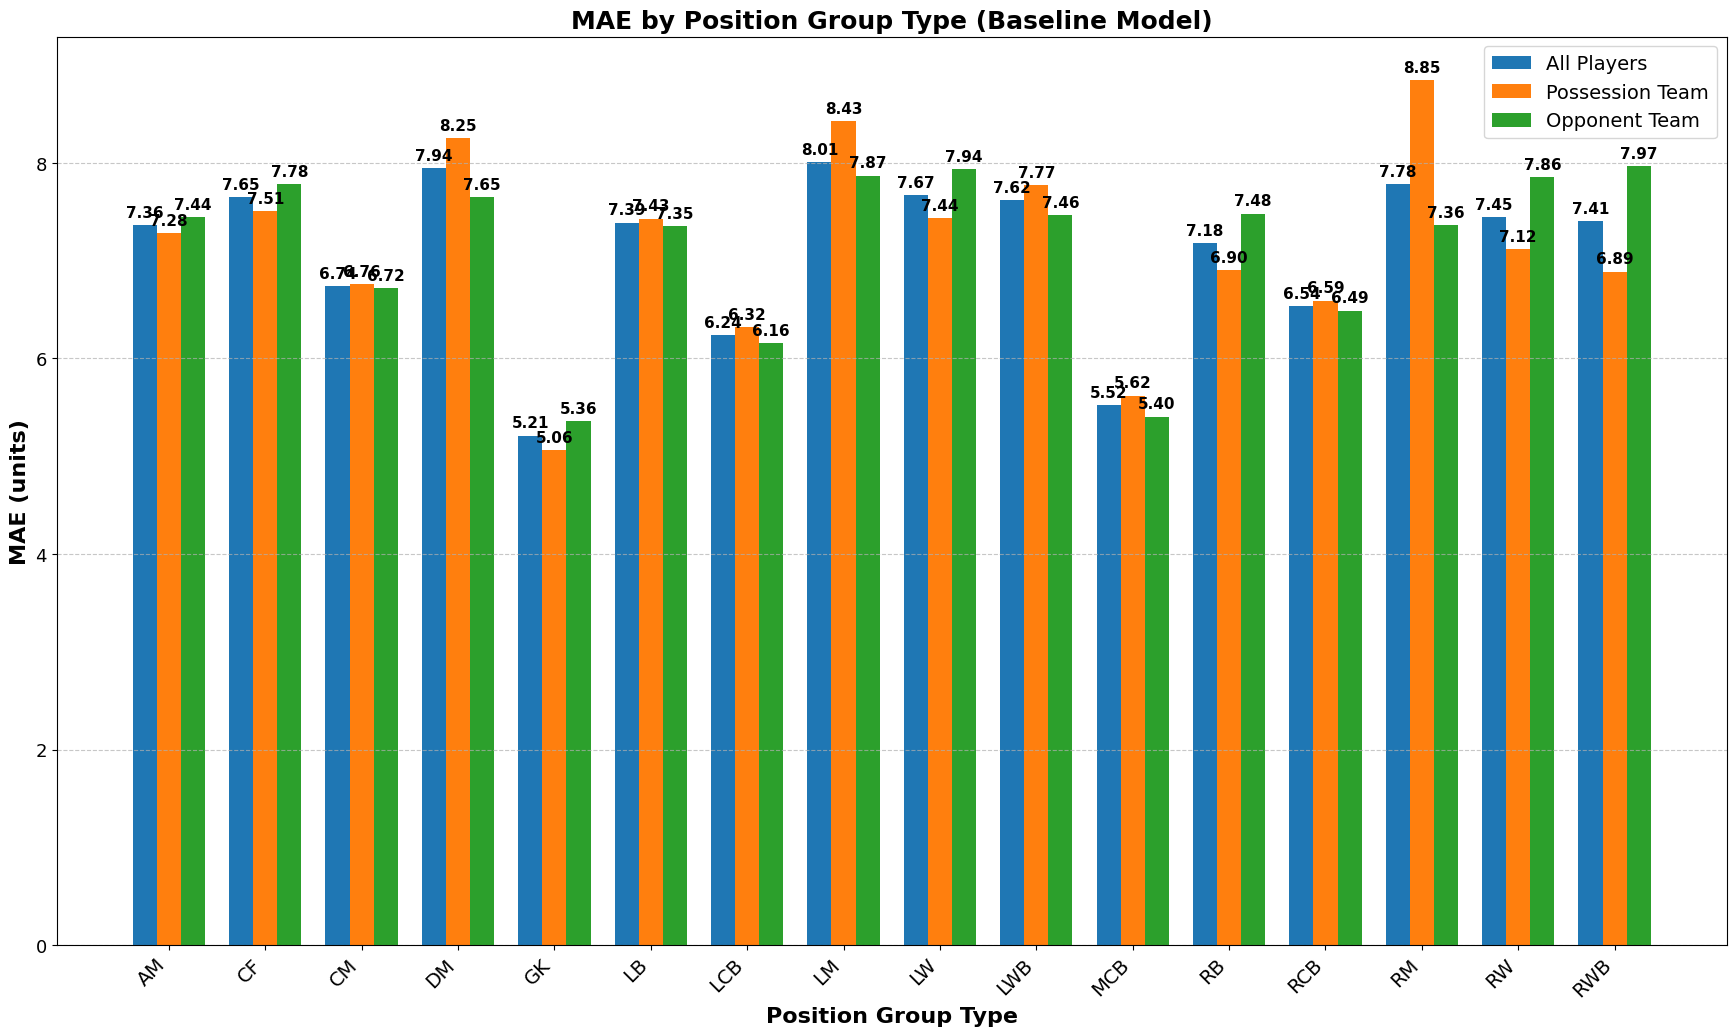


🔍 ADDITIONAL INSIGHTS FROM THE VISUALIZATION:
1. The visualization shows how model performance varies across different position types
2. Positions with lower MAE values indicate where the model makes more accurate predictions
3. Positions with higher MAE values indicate where the model struggles with predictions
4. Comparing Possession Team vs Opponent Team MAE reveals if the model performs differently based on team role

📊 Positions with largest performance gap between teams:
   • RM: 1.48 units difference (Opponent team performs better)
   • RWB: 1.08 units difference (Possession team performs better)
   • RW: 0.74 units difference (Possession team performs better)

✅ STEP 3 COMPLETE: Visualization created
   ⏱️  Total execution time: 3.82 seconds

🎉 VISUALIZATION SUCCESSFULLY COMPLETED!
The chart clearly shows how model performance varies across different position types
This helps identify tactical positions where the baseline model needs improvement


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time

print("\n== STEP 3: VISUALIZATION OF MAE BY POSITION GROUP TYPE ==")
start_time = time.time()

# Load the results CSV
print(f"📊 Loading MAE results from: {output_csv_path}")
results_df = pd.read_csv(output_csv_path)

# Filter out positions with no data for visualization
valid_positions = results_df[
    (results_df['Possession Player Count'] > 0) |
    (results_df['Opponent Player Count'] > 0)
].copy()

print(f"   ✅ Loaded data for {len(valid_positions)} position types")

# Set up the bar chart with larger figure size for better readability
plt.figure(figsize=(18, 11))

# Set position of bars on X axis
x = np.arange(len(valid_positions))
width = 0.25  # Width of bars

# Create bars
plt.bar(x - width, valid_positions['MAE for All Players'], width, label='All Players', color='#1f77b4')
plt.bar(x, valid_positions['MAE for Possession Team'], width, label='Possession Team', color='#ff7f0e')
plt.bar(x + width, valid_positions['MAE for Opponent Team'], width, label='Opponent Team', color='#2ca02c')

# Add labels, title and custom x-axis tick labels with larger font sizes
plt.xlabel('Position Group Type', fontsize=16, fontweight='bold')
plt.ylabel('MAE (units)', fontsize=16, fontweight='bold')
plt.title('MAE by Position Group Type (Baseline Model)', fontsize=18, fontweight='bold')
plt.xticks(x, valid_positions['Position Type'], rotation=45, ha='right', fontsize=14)  # Increased from 12 to 14
plt.yticks(fontsize=13)  # Increased from default
plt.legend(fontsize=14)  # Increased from 12 to 14
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars with larger font size
for i, v in enumerate(valid_positions['MAE for All Players']):
    if v > 0:
        plt.text(i - width, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')  # Increased from 9 to 11

for i, v in enumerate(valid_positions['MAE for Possession Team']):
    if v > 0:
        plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')  # Increased from 9 to 11

for i, v in enumerate(valid_positions['MAE for Opponent Team']):
    if v > 0:
        plt.text(i + width, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')  # Increased from 9 to 11

# Adjust layout for better spacing with more room for labels
plt.tight_layout(pad=3.0)  # Increased padding from default

# Save the visualization
chart_path = os.path.join(os.path.dirname(output_csv_path), "MAE_Position_Group_Types_Chart.png")
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Chart saved to: {chart_path}")

# Display the chart
plt.show()

# Print additional insights
print("\n🔍 ADDITIONAL INSIGHTS FROM THE VISUALIZATION:")
print("1. The visualization shows how model performance varies across different position types")
print("2. Positions with lower MAE values indicate where the model makes more accurate predictions")
print("3. Positions with higher MAE values indicate where the model struggles with predictions")
print("4. Comparing Possession Team vs Opponent Team MAE reveals if the model performs differently based on team role")

# Identify positions with largest performance gap between teams
if not valid_positions.empty:
    valid_positions['Team_Difference'] = abs(valid_positions['MAE for Possession Team'] - valid_positions['MAE for Opponent Team'])
    largest_gap = valid_positions.nlargest(3, 'Team_Difference')

    print("\n📊 Positions with largest performance gap between teams:")
    for _, row in largest_gap.iterrows():
        diff = row['MAE for Possession Team'] - row['MAE for Opponent Team']
        if abs(diff) > 0.1:  # Only report meaningful differences
            direction = "Possession" if diff < 0 else "Opponent"
            print(f"   • {row['Position Type']}: {abs(diff):.2f} units difference ({direction} team performs better)")
        else:
            print(f"   • {row['Position Type']}: {abs(diff):.2f} units difference (nearly equal performance)")

total_time = time.time() - start_time
print(f"\n✅ STEP 3 COMPLETE: Visualization created")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 VISUALIZATION SUCCESSFULLY COMPLETED!")
print("The chart clearly shows how model performance varies across different position types")
print("This helps identify tactical positions where the baseline model needs improvement")

# **Overall_MAE_Position_Group_Type_Results_Figure**

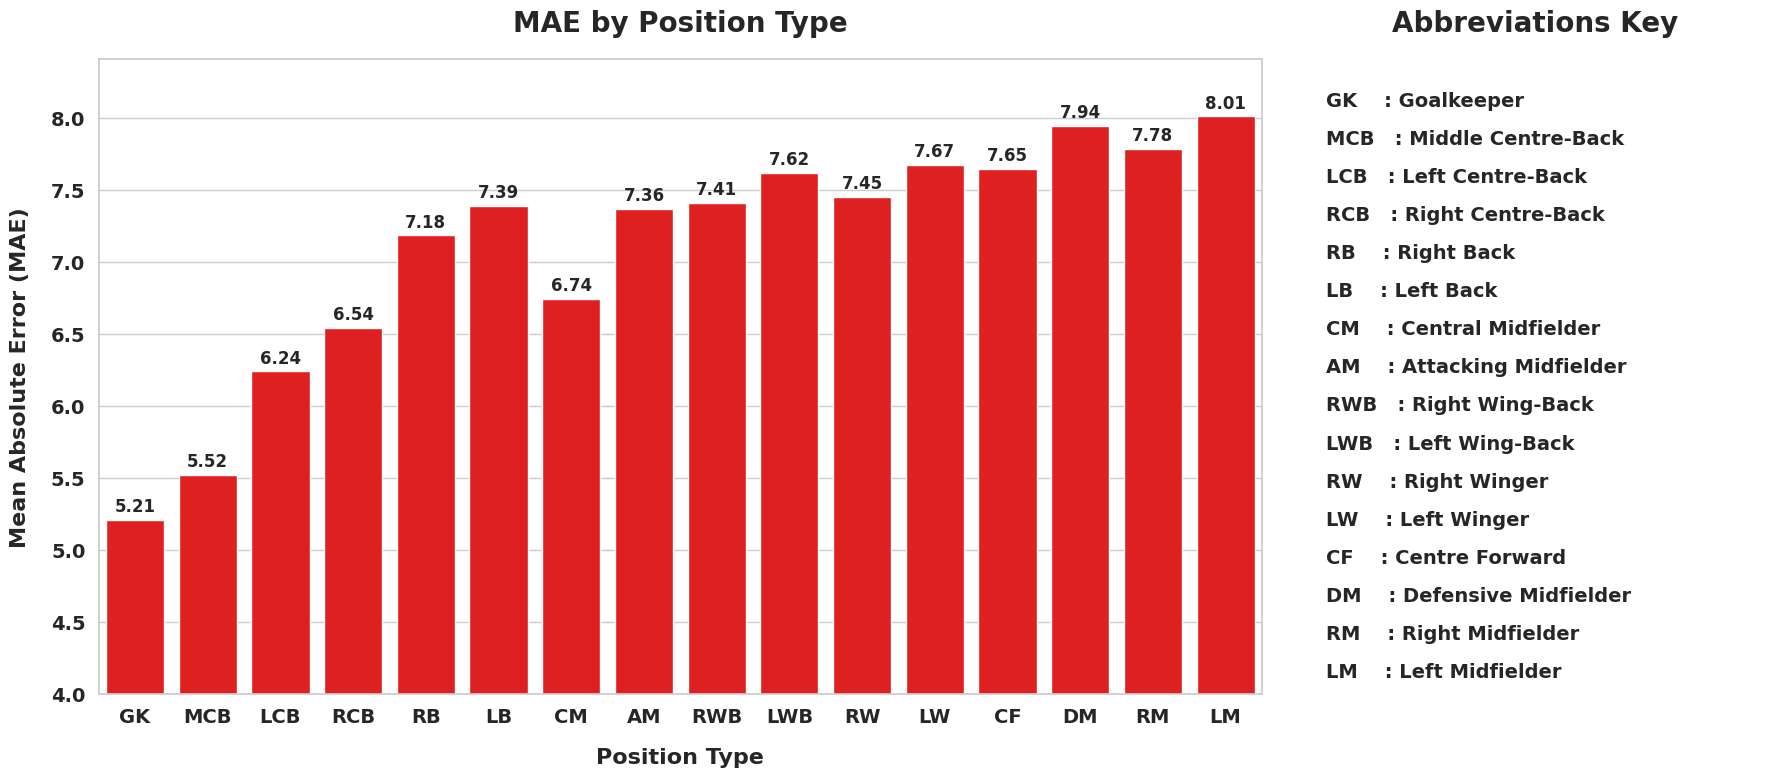

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Preparation ---

data_source = {
    'Position Type': ['GK', 'MCB', 'LCB', 'RCB', 'RB', 'LB', 'CM', 'AM',
                      'RWB', 'LWB', 'RW', 'LW', 'CF', 'DM', 'RM', 'LM'],
    'MAE': [5.210988, 5.5193024, 6.2389665, 6.538104, 7.182543, 7.389001,
            6.7405376, 7.36404, 7.4064345, 7.618843, 7.448063, 7.671365,
            7.6464534, 7.94462, 7.782439, 8.008459]
}
df_plot = pd.DataFrame(data_source)

abbreviations_dict = {
    'GK': 'Goalkeeper',
    'MCB': 'Middle Centre-Back',
    'LCB': 'Left Centre-Back',
    'RCB': 'Right Centre-Back',
    'RB': 'Right Back',
    'LB': 'Left Back',
    'DM': 'Defensive Midfielder',
    'RWB': 'Right Wing-Back',
    'LWB': 'Left Wing-Back',
    'CM': 'Central Midfielder',
    'LM': 'Left Midfielder',
    'RM': 'Right Midfielder',
    'AM': 'Attacking Midfielder',
    'RW': 'Right Winger',
    'LW': 'Left Winger',
    'CF': 'Centre Forward'
}

# --- 2. Professional Styling Setup ---

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

# --- 3. Plotting Construction ---

fig, (ax_plot, ax_legend) = plt.subplots(
    nrows=1, ncols=2, figsize=(18, 8), gridspec_kw={'width_ratios': [3, 1.2]}
)

# --- THE PLOT (Left Axis) ---
plot_order = df_plot['Position Type'].tolist()

sns.barplot(
    data=df_plot,
    x='Position Type',
    y='MAE',
    color='red',
    ax=ax_plot,
    order=plot_order
)

# *** MODIFICATION HERE: Start Y-axis from 4 ***
ax_plot.set_ylim(bottom=4)

ax_plot.set_title("MAE by Position Type", pad=20)
ax_plot.set_xlabel("Position Type", labelpad=15)
ax_plot.set_ylabel("Mean Absolute Error (MAE)", labelpad=15)

# Add value labels
for p in ax_plot.patches:
    ax_plot.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points',
                   fontweight='bold', fontsize=12)

# --- THE LEGEND (Right Axis) ---
ax_legend.axis('off')
ax_legend.set_title("Abbreviations Key", pad=20)

y_pos = 0.95
line_spacing = 0.06

for pos_code in plot_order:
    meaning = abbreviations_dict.get(pos_code, "Unknown")
    legend_text = f"{pos_code:<5} : {meaning}"
    ax_legend.text(
        0.05, y_pos,
        legend_text,
        transform=ax_legend.transAxes,
        fontsize=14,
        fontweight='bold',
        verticalalignment='top'
    )
    y_pos -= line_spacing

plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

# **MAE_VS_T4_Dispersion_Baseline_Model**

## **Tested_on_Baseline**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: BASELINE SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion"
output_csv_path = os.path.join(output_dir, "MAE_Baseline_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Baseline predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete data: {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Baseline team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Baseline team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: BASELINE SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/MAE_Baseline_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion

📊 Loading Baseline predicted players CSV with memory optimiza

== STEP 2: BASELINE SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/MAE_Baseline_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Baseline_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion

📊 Loading Baseline sequence-level metrics CSV...
   ✅ CSV loaded in 0.02 seconds
   ✅ Shape: 1,504 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 8.42 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/F

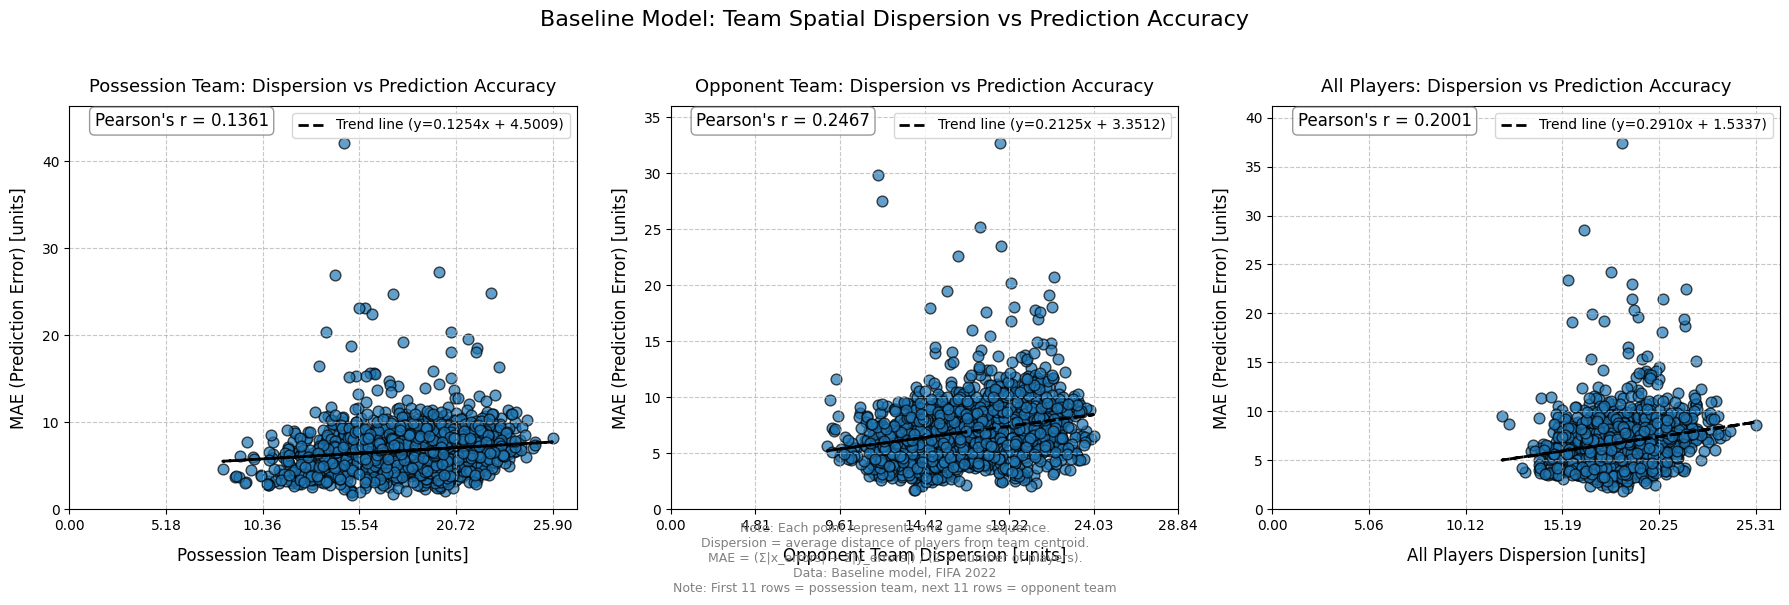


✅ STEP 2 COMPLETE: Baseline dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 9.60 seconds

🎉 BASELINE DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Baseline_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using neutral blue color for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: BASELINE SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/MAE_Baseline_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion"
output_plot_path = os.path.join(output_dir, "Baseline_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Baseline sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Use a neutral blue color for visualization
neutral_color = '#1f77b4'  # Standard blue from matplotlib default color cycle

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=neutral_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=neutral_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=neutral_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Baseline Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Baseline dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 BASELINE DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using neutral blue color for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_France**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/France_Test/predictions/predicted_players_france.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France"
output_csv_path = os.path.join(output_dir, "MAE_France_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading France predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: France team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for France team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/France_Test/predictions/predicted_players_france.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France/MAE_France_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France

📊 Loading France predicted

== STEP 2: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France/MAE_France_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France/France_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France

📊 Loading France sequence-level metrics CSV...
   ✅ CSV loaded in 0.07 seconds
   ✅ Shape: 1,617 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 4.94 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_

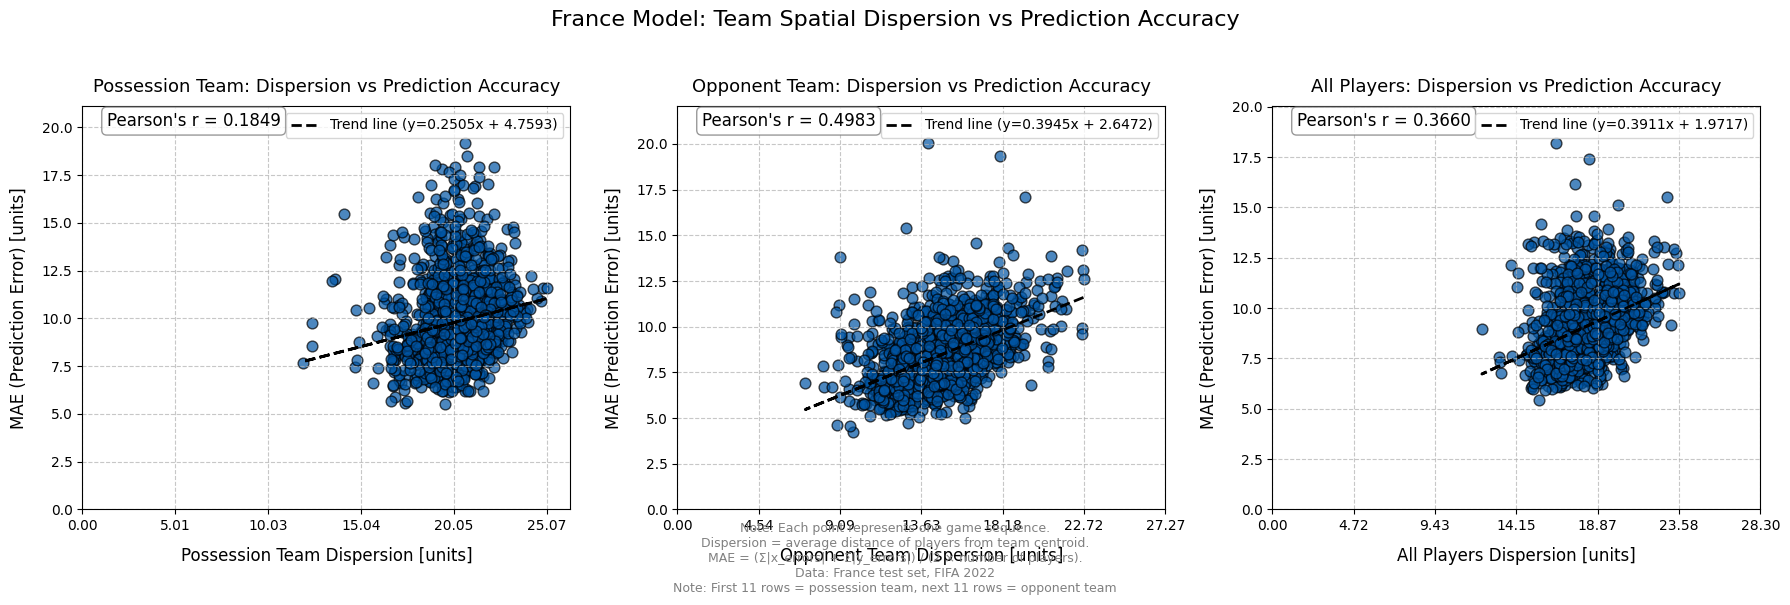


✅ STEP 2 COMPLETE: France dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 6.01 seconds

🎉 FRANCE DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France/France_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using blue color (from French flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France/MAE_France_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/France"
output_plot_path = os.path.join(output_dir, "France_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading France sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Use France colors (blue, white, red - but primarily blue for visualization)
france_color = '#0055A4'  # Blue from French flag

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('France Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: France test set, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: France dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 FRANCE DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using blue color (from French flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_England**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/England_Test/predictions/predicted_players_england.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England"
output_csv_path = os.path.join(output_dir, "MAE_England_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading England predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: England team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for England team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/England_Test/predictions/predicted_players_england.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England/MAE_England_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England

📊 Loading England p

== STEP 2: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England/MAE_England_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England/England_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England

📊 Loading England sequence-level metrics CSV...
   ✅ CSV loaded in 0.06 seconds
   ✅ Shape: 1,547 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 3.42 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2For

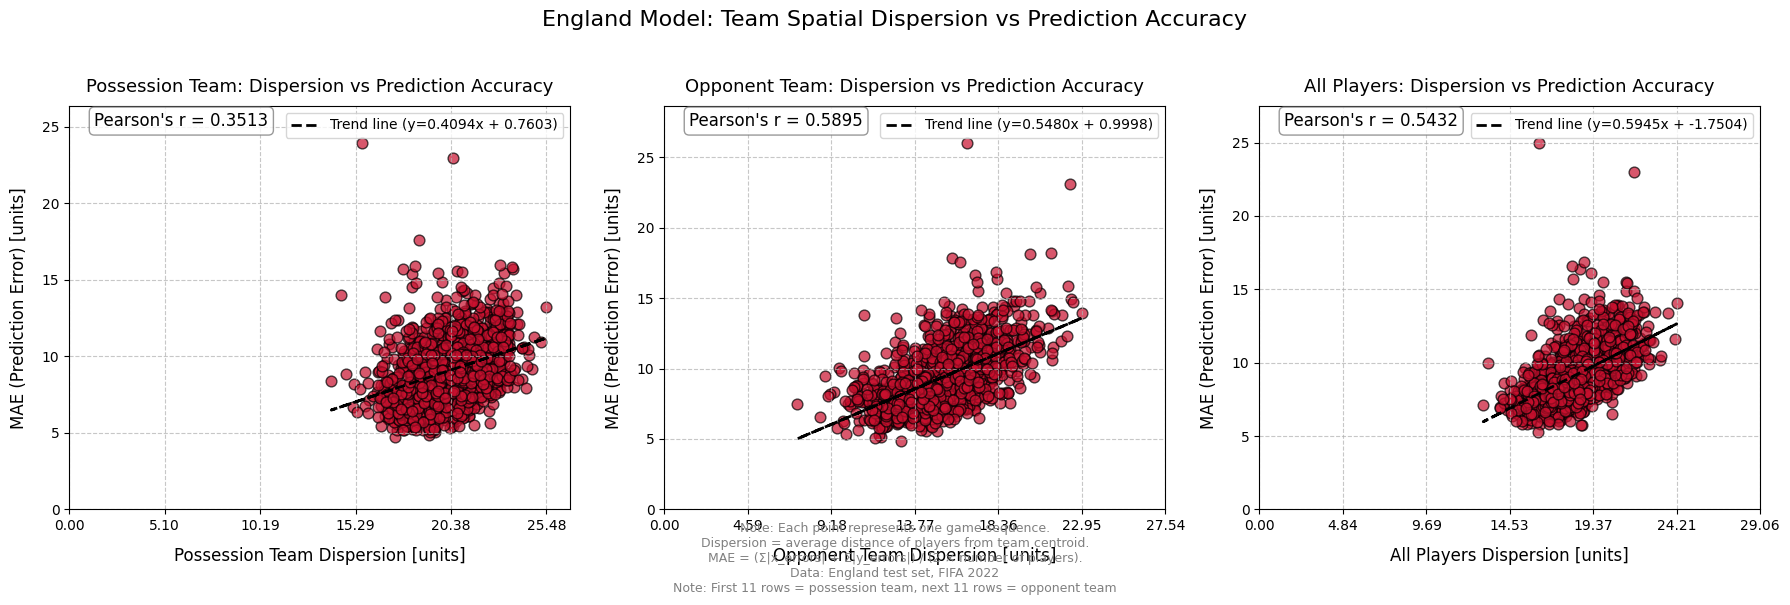


✅ STEP 2 COMPLETE: England dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 4.63 seconds

🎉 ENGLAND DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England/England_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from England flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England/MAE_England_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/England"
output_plot_path = os.path.join(output_dir, "England_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading England sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Use England colors (red and white)
england_color = '#C8102E'  # England red from flag

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('England Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: England test set, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: England dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ENGLAND DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from England flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_Croatia**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Croatia_Test/predictions/predicted_players_croatia.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia"
output_csv_path = os.path.join(output_dir, "MAE_Croatia_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Croatia predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Croatia team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Croatia team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Croatia_Test/predictions/predicted_players_croatia.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia/MAE_Croatia_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia

📊 Loading Croatia p

== STEP 2: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia/MAE_Croatia_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia/Croatia_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia

📊 Loading Croatia sequence-level metrics CSV...
   ✅ CSV loaded in 0.03 seconds
   ✅ Shape: 1,694 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 4.95 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2For

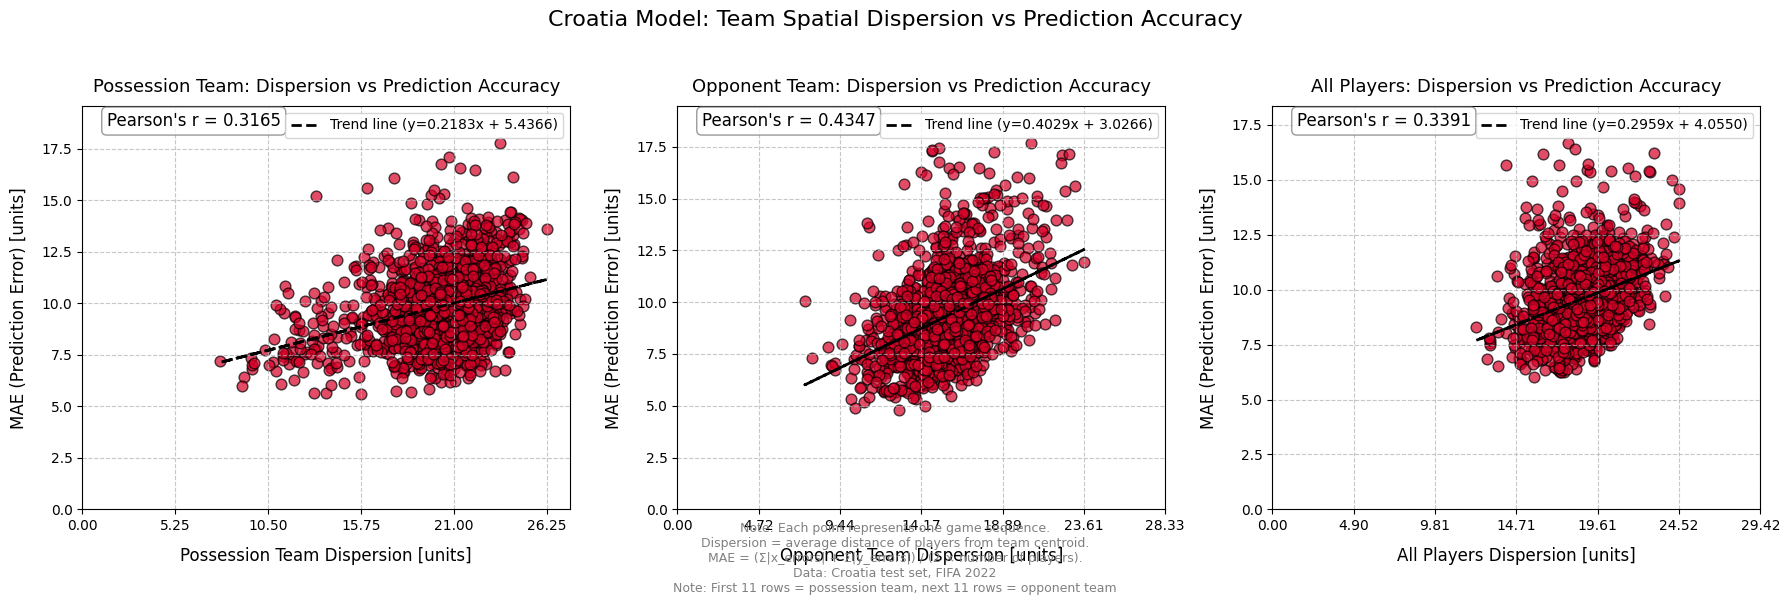


✅ STEP 2 COMPLETE: Croatia dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 5.87 seconds

🎉 CROATIA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia/Croatia_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from Croatia flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia/MAE_Croatia_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Croatia"
output_plot_path = os.path.join(output_dir, "Croatia_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Croatia sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Use Croatia colors (red and blue - red is dominant in flag)
croatia_color = '#D80027'  # Red from Croatia flag

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Croatia Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Croatia test set, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Croatia dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 CROATIA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from Croatia flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_Morocco**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Morocco_Test/predictions/predicted_players_morocco.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco"
output_csv_path = os.path.join(output_dir, "MAE_Morocco_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Morocco predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Morocco team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Morocco team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Morocco_Test/predictions/predicted_players_morocco.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco/MAE_Morocco_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco

📊 Loading Morocco p

== STEP 2: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco/MAE_Morocco_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco/Morocco_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco

📊 Loading Morocco sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 853 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 5.45 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Forma

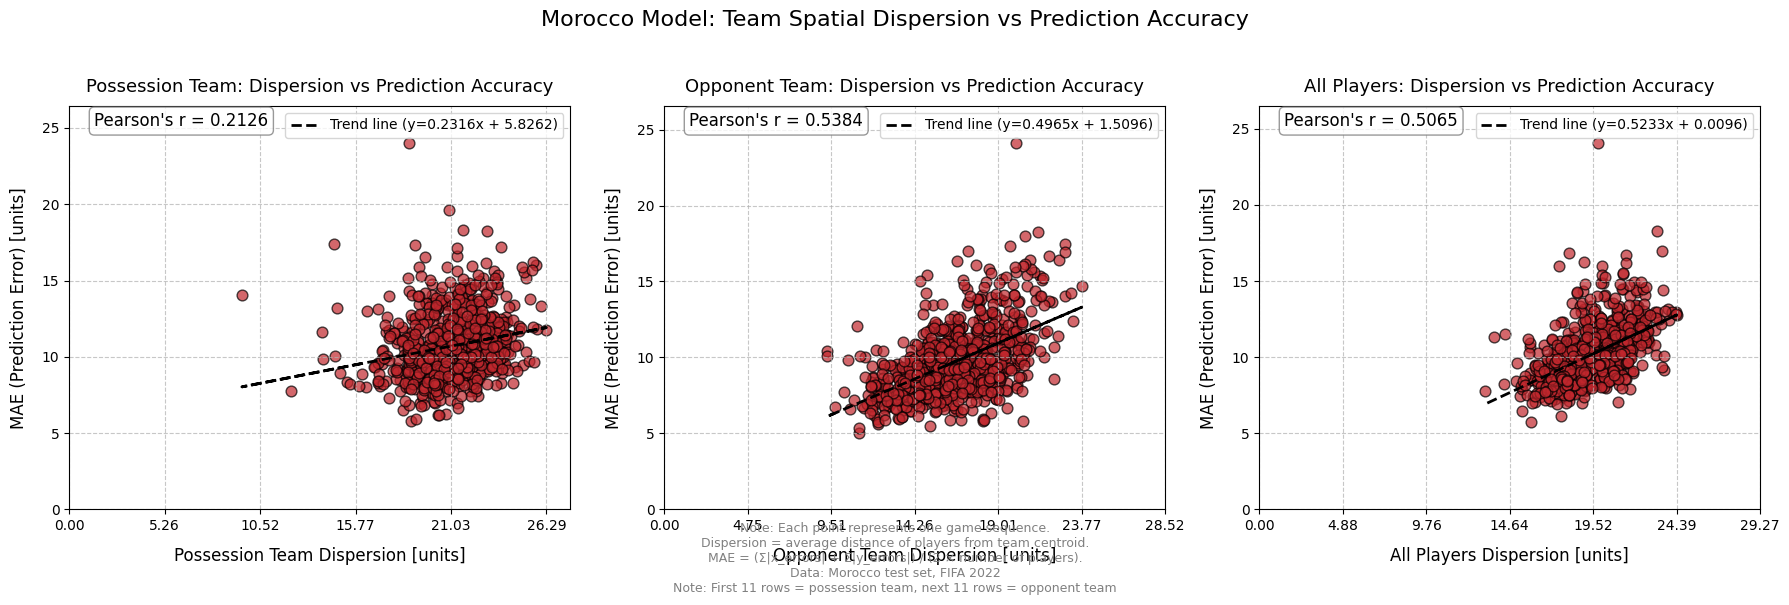


✅ STEP 2 COMPLETE: Morocco dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 6.81 seconds

🎉 MOROCCO DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco/Morocco_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from Morocco flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco/MAE_Morocco_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Morocco"
output_plot_path = os.path.join(output_dir, "Morocco_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Morocco sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Use Morocco colors (red and green - red is dominant in flag)
morocco_color = '#C1272D'  # Red from Morocco flag

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Morocco Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Morocco test set, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Morocco dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MOROCCO DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from Morocco flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_Argentina**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Argentina_Test/predictions/predicted_players_argentina.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina"
output_csv_path = os.path.join(output_dir, "MAE_Argentina_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Argentina predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Argentina team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Argentina team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Argentina_Test/predictions/predicted_players_argentina.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina/MAE_Argentina_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina

📊 Loa

== STEP 2: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina/MAE_Argentina_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina/Argentina_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina

📊 Loading Argentina sequence-level metrics CSV...
   ✅ CSV loaded in 0.05 seconds
   ✅ Shape: 2,016 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 6.45 seconds
   ✅ Plot saved to: /content/drive/My

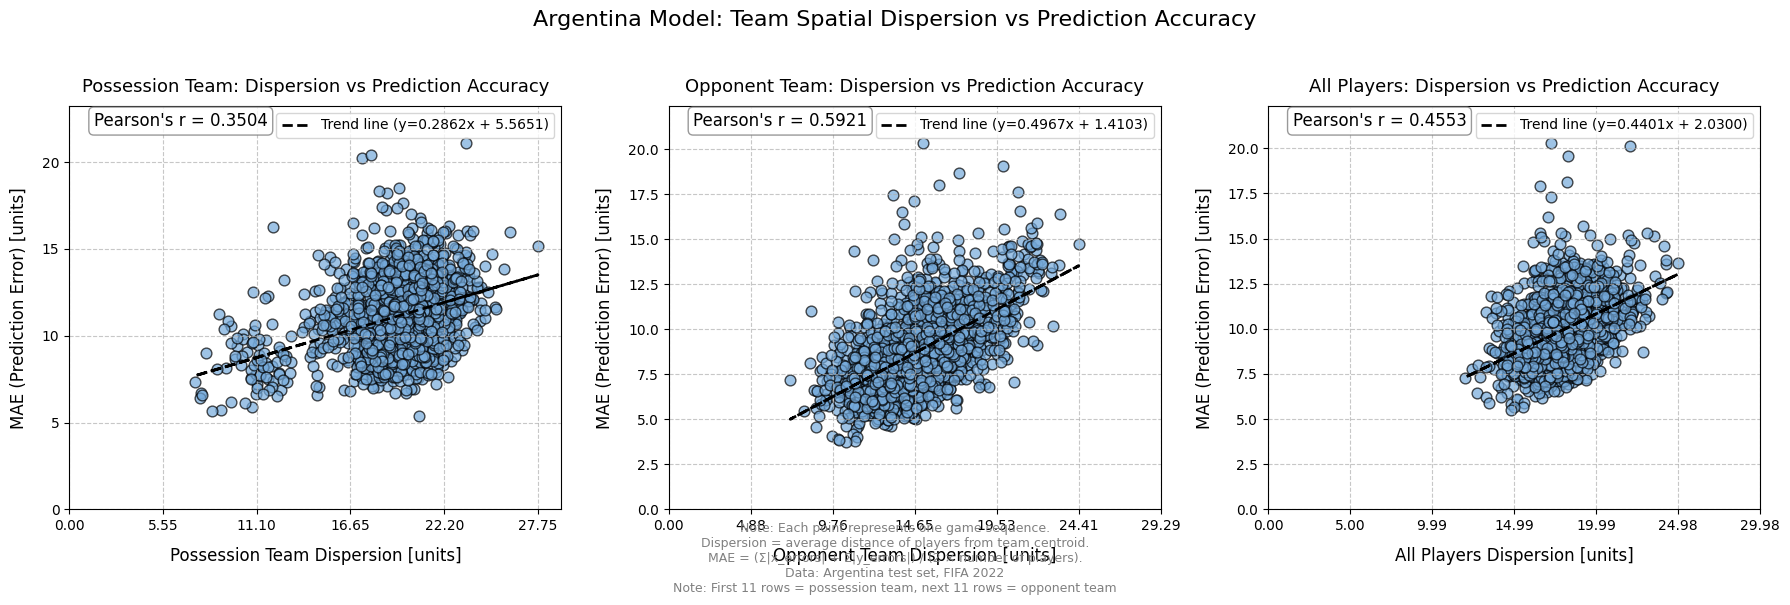


✅ STEP 2 COMPLETE: Argentina dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 7.51 seconds

🎉 ARGENTINA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina/Argentina_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using light blue color (from Argentina flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina/MAE_Argentina_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/MAE_Different_Results/MAE_T4_Dispersion/Argentina"
output_plot_path = os.path.join(output_dir, "Argentina_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Argentina sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Use Argentina colors (light blue and white - blue is dominant in flag)
argentina_color = '#75AADB'  # Light blue from Argentina flag

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Argentina Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Argentina test set, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Argentina dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ARGENTINA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using light blue color (from Argentina flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

# **MAE_VS_T4_Dispersion_FT_France_Model**

## **Tested_on_France**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion"
output_csv_path = os.path.join(output_dir, "MAE_France_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading France predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete data: {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: France team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for France team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

== STEP 1: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Baseline_Model_Fine_Tunned_France/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/MAE_France_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion

📊 Loading France predicted players CSV with memory optimization...
   ✅ CSV loaded in 0.56 seconds
   ✅ Shape: 23,100 rows, 5 columns
   ✅ Memory usage: 0.31 MB

🔍 Filtering for timesteps 4 and 5 only...
   ✅ Filtered in 0.01 seconds
   ✅ Remaining rows: 11,550 (timesteps

== STEP 2: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/MAE_France_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/France_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion

📊 Loading France sequence-level metrics CSV...
   ✅ CSV loaded in 0.00 seconds
   ✅ Shape: 175 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 2.01 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/France_Dispersion_vs_MAE.png

🔍 KEY STATISTICS FROM VISUALIZATION:
   • Possession Team:
     - Minimum MAE:

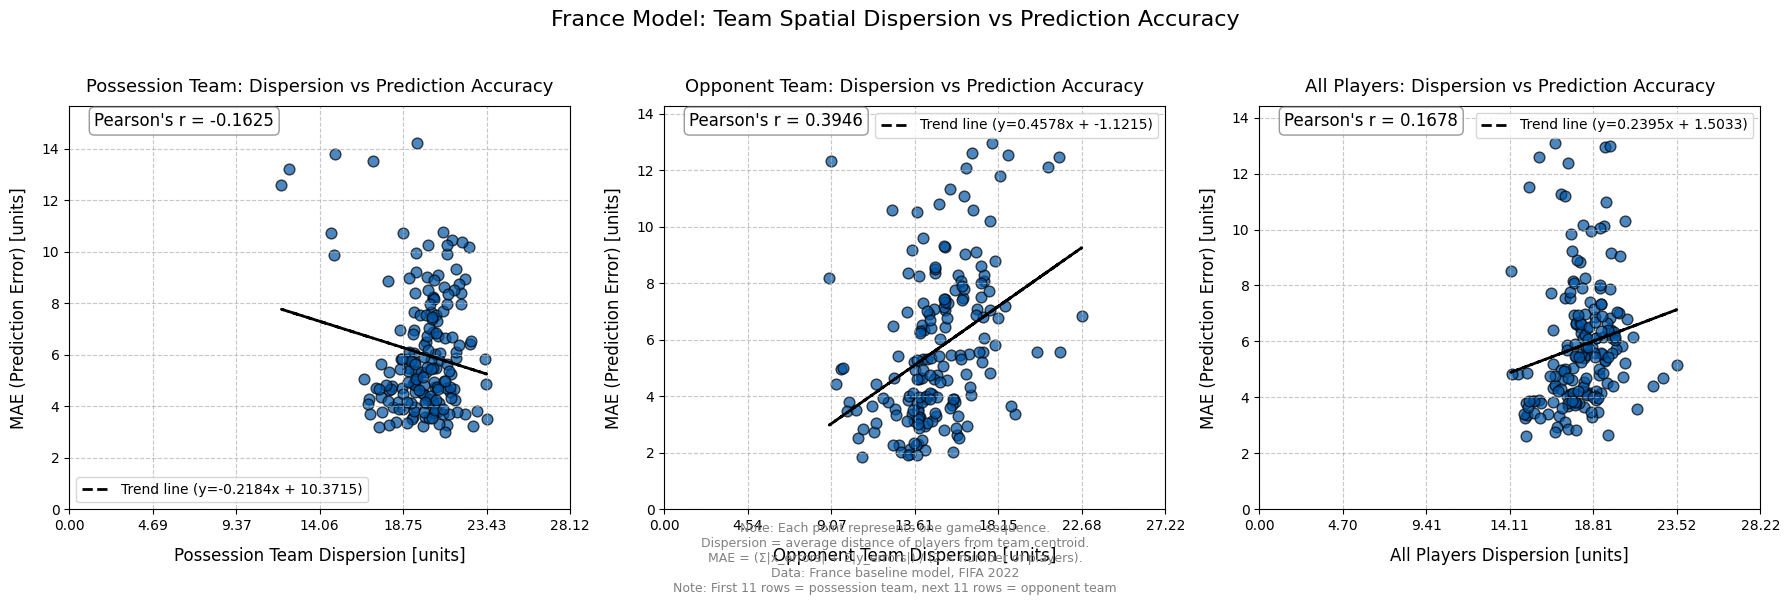


✅ STEP 2 COMPLETE: France dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 2.34 seconds

🎉 FRANCE DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/France_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using blue color (from French flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: FRANCE SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/MAE_France_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion"
output_plot_path = os.path.join(output_dir, "France_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading France sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for France (blue from French flag)
france_color = '#0055A4'

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=france_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('France Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: France baseline model, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: France dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 FRANCE DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using blue color (from French flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")

## **Tested_on_England**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/England/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England"
output_csv_path = os.path.join(output_dir, "MAE_England_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading England predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: England team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for England team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using England team colors (red #EA1F29) for visualization")

== STEP 1: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/England/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England/MAE_England_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England

📊 Loading England predicted players CSV with memory optimization...
   ✅ CSV loaded in 0.97 seconds
   ✅ Shape: 204,204 rows, 5 columns
   ✅ Memory usage: 2.73 MB

🔍 Filtering for timesteps 4 and 5 only...
   ✅ Filtered in 0.01 seconds


== STEP 2: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England/MAE_England_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England/England_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England

📊 Loading England sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 1,547 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 2.01 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England/England_Dispersion_vs_MAE.png

🔍 KEY STATISTICS FROM VISUA

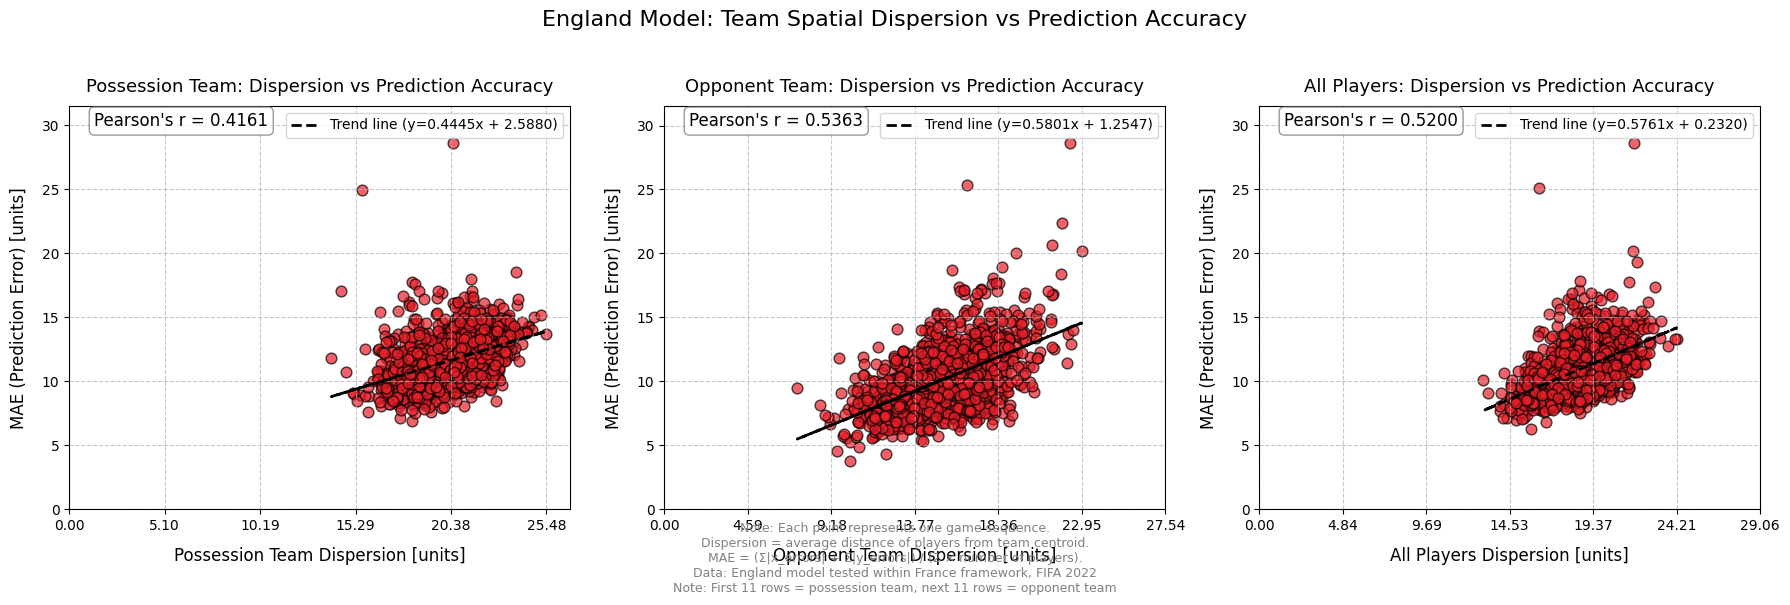


✅ STEP 2 COMPLETE: England dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 2.63 seconds

🎉 ENGLAND DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England/England_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from England flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: England model tested within France framework


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ENGLAND SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England/MAE_England_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_England"
output_plot_path = os.path.join(output_dir, "England_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading England sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for England (red from England flag)
england_color = '#EA1F29'

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=england_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('England Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: England model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: England dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ENGLAND DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from England flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: England model tested within France framework")

## **Tested_on_Croatia**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Croatia/predictions/predicted_players_croatia.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia"
output_csv_path = os.path.join(output_dir, "MAE_Croatia_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Croatia predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Croatia team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Croatia team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using Croatia team colors (red #C8102E, white #FFFFFF, blue #0047AB) for visualization")

== STEP 1: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Croatia/predictions/predicted_players_croatia.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia/MAE_Croatia_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia

📊 Loading Croatia predicted players CSV with memory optimization...
   ✅ CSV loaded in 1.17 seconds
   ✅ Shape: 223,608 rows, 5 columns
   ✅ Memory usage: 2.99 MB

🔍 Filtering for timesteps 4 and 5 only...
   ✅ Filtered in 0.01 

== STEP 2: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia/MAE_Croatia_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia/Croatia_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia

📊 Loading Croatia sequence-level metrics CSV...
   ✅ CSV loaded in 0.02 seconds
   ✅ Shape: 1,694 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 3.68 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia/Croatia_Dispersion_vs_MAE.png

🔍 KEY STATISTICS FROM VISUA

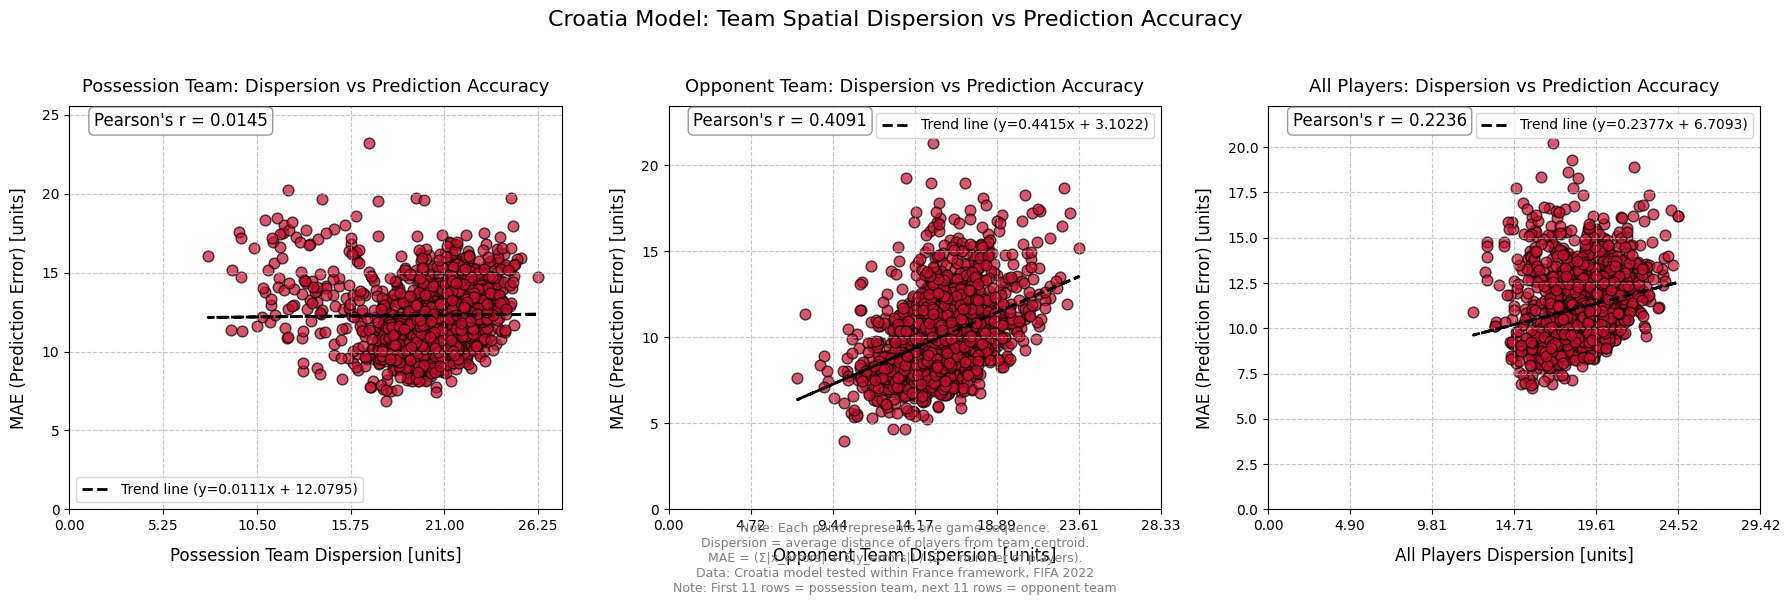


✅ STEP 2 COMPLETE: Croatia dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 4.27 seconds

🎉 CROATIA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia/Croatia_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from Croatia flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Croatia model tested within France framework


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: CROATIA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia/MAE_Croatia_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Croatia"
output_plot_path = os.path.join(output_dir, "Croatia_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Croatia sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for Croatia (red from Croatia flag)
croatia_color = '#C8102E'

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=croatia_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Croatia Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Croatia model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Croatia dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 CROATIA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from Croatia flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Croatia model tested within France framework")

## **Tested_on_Morocco**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Morocco/predictions/predicted_players_morocco.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco"
output_csv_path = os.path.join(output_dir, "MAE_Morocco_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Morocco predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Morocco team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Morocco team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using Morocco team colors (red #C1272D, green #006233) for visualization")

== STEP 1: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Morocco/predictions/predicted_players_morocco.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco/MAE_Morocco_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco

📊 Loading Morocco predicted players CSV with memory optimization...
   ✅ CSV loaded in 0.90 seconds
   ✅ Shape: 112,596 rows, 5 columns
   ✅ Memory usage: 1.50 MB

🔍 Filtering for timesteps 4 and 5 only...
   ✅ Filtered in 0.00 

== STEP 2: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco/MAE_Morocco_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco/Morocco_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco

📊 Loading Morocco sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 853 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 1.68 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco/Morocco_Dispersion_vs_MAE.png

🔍 KEY STATISTICS FROM VISUALI

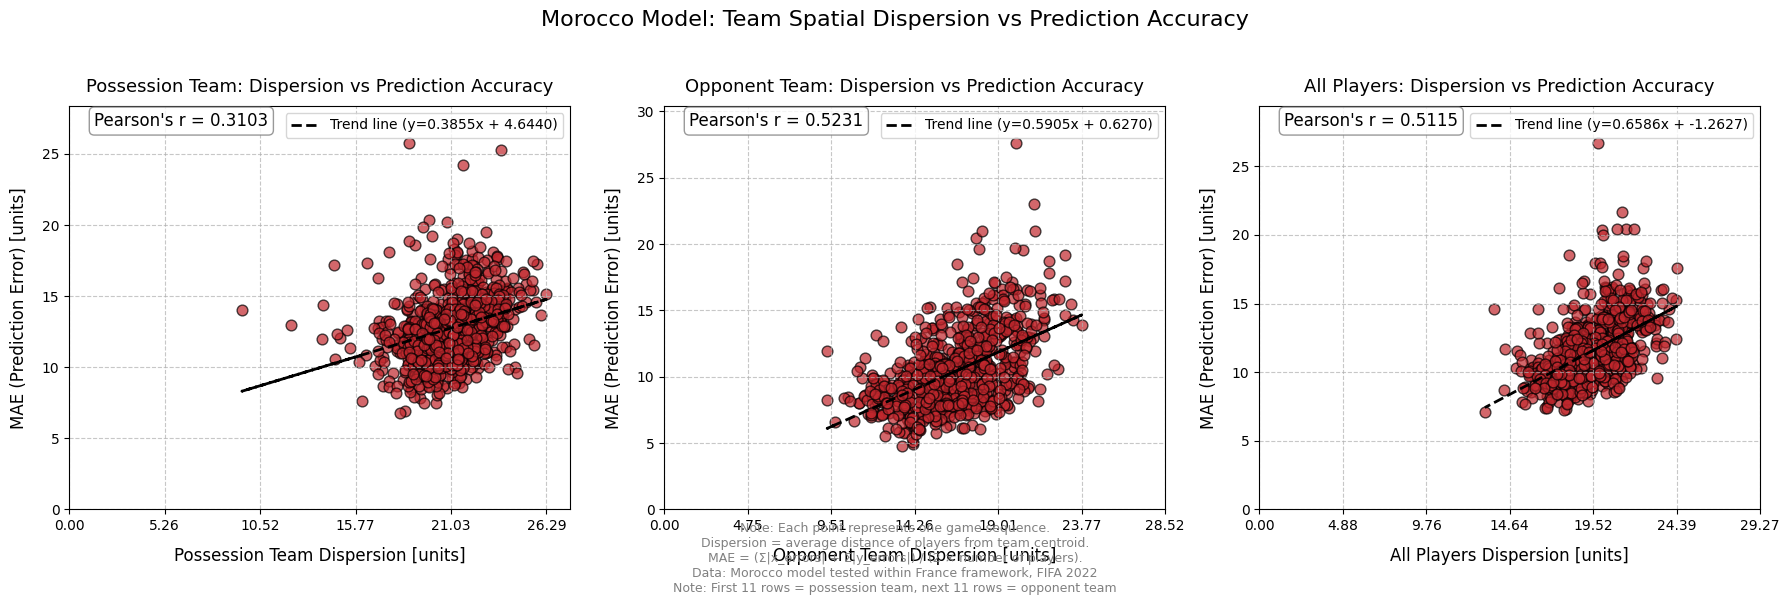


✅ STEP 2 COMPLETE: Morocco dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 2.02 seconds

🎉 MOROCCO DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco/Morocco_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using red color (from Morocco flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Morocco model tested within France framework


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: MOROCCO SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco/MAE_Morocco_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Morocco"
output_plot_path = os.path.join(output_dir, "Morocco_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Morocco sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for Morocco (red from Morocco flag)
morocco_color = '#C1272D'

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=morocco_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Morocco Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Morocco model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Morocco dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 MOROCCO DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using red color (from Morocco flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Morocco model tested within France framework")

## **Tested_on_Argentina**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Argentina/predictions/predicted_players_argentina.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina"
output_csv_path = os.path.join(output_dir, "MAE_Argentina_Dispersion.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Argentina predicted players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32'
}

# Load only required columns
df = pd.read_csv(
    input_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"   ✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter to only keep timesteps 4 and 5
print("\n🔍 Filtering for timesteps 4 and 5 only...")
start_filter = time.time()
df = df[df['timestep'].isin([4, 5])].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {df.shape[0]:,} (timesteps 4 and 5 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = df[df['global_sequence_id'] == seq_id]

    # Split into required components
    t4 = seq_data[seq_data['timestep'] == 4].reset_index(drop=True)
    t5 = seq_data[seq_data['timestep'] == 5].reset_index(drop=True)
    t5_actual = t5[t5['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5[t5['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t4) != 22 or len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate team centroids at timestep 4
    # First 11 rows = possession team, next 11 rows = opponent team
    possession_team = t4.iloc[:11]
    opponent_team = t4.iloc[11:22]
    all_players = t4

    # Calculate centroids
    possession_centroid_x = possession_team['x'].mean()
    possession_centroid_y = possession_team['y'].mean()
    opponent_centroid_x = opponent_team['x'].mean()
    opponent_centroid_y = opponent_team['y'].mean()
    all_players_centroid_x = all_players['x'].mean()
    all_players_centroid_y = all_players['y'].mean()

    # Calculate dispersion for possession team (average distance from centroid)
    possession_distances = np.sqrt(
        (possession_team['x'] - possession_centroid_x)**2 +
        (possession_team['y'] - possession_centroid_y)**2
    )
    possession_dispersion = possession_distances.mean()

    # Calculate dispersion for opponent team
    opponent_distances = np.sqrt(
        (opponent_team['x'] - opponent_centroid_x)**2 +
        (opponent_team['y'] - opponent_centroid_y)**2
    )
    opponent_dispersion = opponent_distances.mean()

    # Calculate dispersion for all players
    all_players_distances = np.sqrt(
        (all_players['x'] - all_players_centroid_x)**2 +
        (all_players['y'] - all_players_centroid_y)**2
    )
    all_players_dispersion = all_players_distances.mean()

    # Calculate MAE for possession team (first 11 players)
    possession_actual = t5_actual.iloc[:11]
    possession_predicted = t5_predicted.iloc[:11]
    possession_x_errors = np.abs(possession_actual['x'].values - possession_predicted['x'].values)
    possession_y_errors = np.abs(possession_actual['y'].values - possession_predicted['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_actual = t5_actual.iloc[11:22]
    opponent_predicted = t5_predicted.iloc[11:22]
    opponent_x_errors = np.abs(opponent_actual['x'].values - opponent_predicted['x'].values)
    opponent_y_errors = np.abs(opponent_actual['y'].values - opponent_predicted['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'possession_team_dispersion': float(possession_dispersion),
        'opponent_team_dispersion': float(opponent_dispersion),
        'all_players_dispersion': float(all_players_dispersion),
        'possession_team_MAE': float(possession_mae),
        'opponent_team_MAE': float(opponent_mae),
        'all_players_MAE': float(all_players_mae),
        'possession_team_centroid_x': float(possession_centroid_x),
        'possession_team_centroid_y': float(possession_centroid_y),
        'opponent_team_centroid_x': float(opponent_centroid_x),
        'opponent_team_centroid_y': float(opponent_centroid_y),
        'all_players_centroid_x': float(all_players_centroid_x),
        'all_players_centroid_y': float(all_players_centroid_y)
    })

print(f"\n✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'possession_team_dispersion',
    'opponent_team_dispersion',
    'all_players_dispersion',
    'possession_team_MAE',
    'opponent_team_MAE',
    'all_players_MAE',
    'possession_team_centroid_x',
    'possession_team_centroid_y',
    'opponent_team_centroid_x',
    'opponent_team_centroid_y',
    'all_players_centroid_x',
    'all_players_centroid_y'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Poss Disp={row['possession_team_dispersion']:.3f}, Opp Disp={row['opponent_team_dispersion']:.3f}, All Disp={row['all_players_dispersion']:.3f}, "
          f"Poss MAE={row['possession_team_MAE']:.3f}, Opp MAE={row['opponent_team_MAE']:.3f}, All MAE={row['all_players_MAE']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Average Possession Team Dispersion: {results_df['possession_team_dispersion'].mean():.3f} units")
print(f"   • Average Opponent Team Dispersion: {results_df['opponent_team_dispersion'].mean():.3f} units")
print(f"   • Average All Players Dispersion: {results_df['all_players_dispersion'].mean():.3f} units")
print(f"   • Average Possession Team MAE: {results_df['possession_team_MAE'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['opponent_team_MAE'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['all_players_MAE'].mean():.3f} units")
print(f"   • Correlation (Possession Dispersion vs MAE): {results_df['possession_team_dispersion'].corr(results_df['possession_team_MAE']):.4f}")
print(f"   • Correlation (Opponent Dispersion vs MAE): {results_df['opponent_team_dispersion'].corr(results_df['opponent_team_MAE']):.4f}")
print(f"   • Correlation (All Players Dispersion vs MAE): {results_df['all_players_dispersion'].corr(results_df['all_players_MAE']):.4f}")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Argentina team dispersion vs MAE correlation analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Generate visualization for Argentina team dispersion vs MAE")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print("      Dispersion = average distance of players from team centroid")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using Argentina team colors (light blue #75AADB) for visualization")

== STEP 1: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE CORRELATION ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/V4_Fine_Tunned_Different_Test/Argentina/predictions/predicted_players_argentina.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina/MAE_Argentina_Dispersion.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina

📊 Loading Argentina predicted players CSV with memory optimization...
   ✅ CSV loaded in 1.23 seconds
   ✅ Shape: 266,112 rows, 5 columns
   ✅ Memory usage: 3.55 MB

🔍 Filtering for timesteps 4 and 5 only...
   ✅ F

== STEP 2: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina/MAE_Argentina_Dispersion.csv
Output plot path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina/Argentina_Dispersion_vs_MAE.png

✅ Output directory confirmed at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina

📊 Loading Argentina sequence-level metrics CSV...
   ✅ CSV loaded in 0.01 seconds
   ✅ Shape: 2,016 rows, 13 columns

🎨 Generating multi-panel visualization...
   ✅ Visualization generated in 1.95 seconds
   ✅ Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina/Argentina_Dispersion_vs_MAE.png

🔍 KEY STA

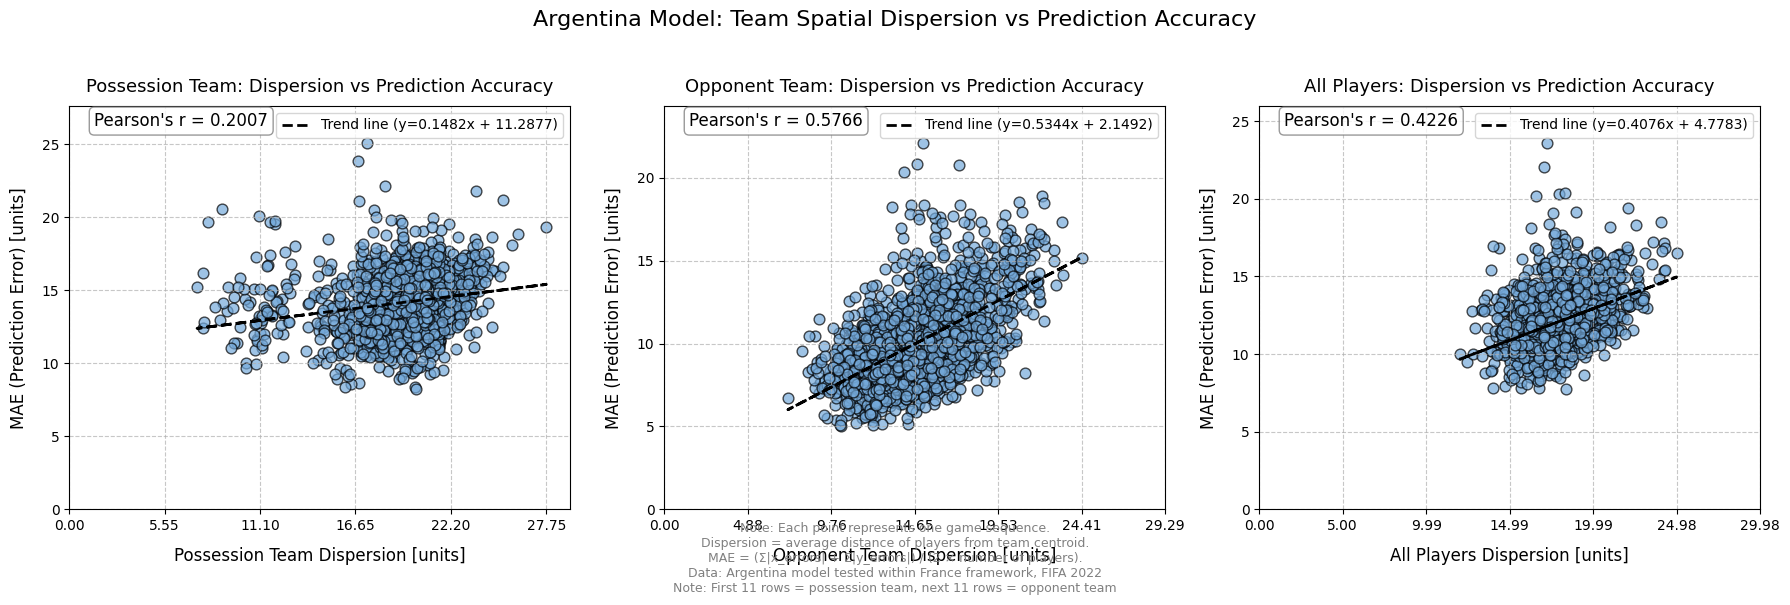


✅ STEP 2 COMPLETE: Argentina dispersion vs MAE visualization generation finished
   ⏱️  Total execution time: 2.43 seconds

🎉 ARGENTINA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!
Plot saved to: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina/Argentina_Dispersion_vs_MAE.png
Note: Three-panel visualization showing:
      • Left: Possession team dispersion vs MAE
      • Middle: Opponent team dispersion vs MAE
      • Right: All players dispersion vs MAE
      Each point represents one unique game sequence
      Correctly using Pearson's r correlation coefficient
      Using light blue color (from Argentina flag) for visualization
      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence
      Note: Argentina model tested within France framework


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: ARGENTINA SEQUENCE-LEVEL TEAM DISPERSION vs MAE VISUALIZATION ==")
start_time = time.time()

# Define file paths
input_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina/MAE_Argentina_Dispersion.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/France/MAE_Different Results/MAE_Dispersion/T4_Argentina"
output_plot_path = os.path.join(output_dir, "Argentina_Dispersion_vs_MAE.png")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {input_csv_path}")
print(f"Output plot path: {output_plot_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory confirmed at: {output_dir}")

# Load the sequence-level metrics CSV
print("\n📊 Loading Argentina sequence-level metrics CSV...")
start_load = time.time()
metrics_df = pd.read_csv(input_csv_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {metrics_df.shape[0]:,} rows, {metrics_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'possession_team_dispersion', 'possession_team_MAE',
    'opponent_team_dispersion', 'opponent_team_MAE',
    'all_players_dispersion', 'all_players_MAE'
]
for col in required_columns:
    if col not in metrics_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Create visualization with 3 subplots
print("\n🎨 Generating multi-panel visualization...")
start_viz = time.time()

# Set up the figure with 3 subplots
plt.figure(figsize=(18, 6))
plt.style.use('default')

# Color for Argentina (light blue from Argentina flag)
argentina_color = '#75AADB'

# Subplot 1: Possession Team
plt.subplot(1, 3, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['possession_team_dispersion'],
    metrics_df['possession_team_MAE'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for possession team
z_poss = np.polyfit(metrics_df['possession_team_dispersion'], metrics_df['possession_team_MAE'], 1)
p_poss = np.poly1d(z_poss)
plt.plot(
    metrics_df['possession_team_dispersion'],
    p_poss(metrics_df['possession_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_poss[0]:.4f}x + {z_poss[1]:.4f})'
)

# Set labels and title for possession team
plt.xlabel('Possession Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Possession Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for possession team
max_poss_disp = metrics_df['possession_team_dispersion'].max()
plt.xlim(0, max_poss_disp * 1.05)
plt.xticks(np.arange(0, max_poss_disp + 5, max(1.0, max_poss_disp/5)))
plt.ylim(0, metrics_df['possession_team_MAE'].max() * 1.1)

# Add correlation coefficient for possession team
poss_correlation = metrics_df['possession_team_dispersion'].corr(metrics_df['possession_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {poss_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 2: Opponent Team
plt.subplot(1, 3, 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['opponent_team_dispersion'],
    metrics_df['opponent_team_MAE'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for opponent team
z_opp = np.polyfit(metrics_df['opponent_team_dispersion'], metrics_df['opponent_team_MAE'], 1)
p_opp = np.poly1d(z_opp)
plt.plot(
    metrics_df['opponent_team_dispersion'],
    p_opp(metrics_df['opponent_team_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_opp[0]:.4f}x + {z_opp[1]:.4f})'
)

# Set labels and title for opponent team
plt.xlabel('Opponent Team Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('Opponent Team: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for opponent team
max_opp_disp = metrics_df['opponent_team_dispersion'].max()
plt.xlim(0, max_opp_disp * 1.05)
plt.xticks(np.arange(0, max_opp_disp + 5, max(1.0, max_opp_disp/5)))
plt.ylim(0, metrics_df['opponent_team_MAE'].max() * 1.1)

# Add correlation coefficient for opponent team
opp_correlation = metrics_df['opponent_team_dispersion'].corr(metrics_df['opponent_team_MAE'])
plt.annotate(
    f'Pearson\'s r = {opp_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Subplot 3: All Players
plt.subplot(1, 3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.scatter(
    metrics_df['all_players_dispersion'],
    metrics_df['all_players_MAE'],
    color=argentina_color,
    alpha=0.7,
    s=60,
    edgecolor='black'
)

# Calculate and plot regression line for all players
z_all = np.polyfit(metrics_df['all_players_dispersion'], metrics_df['all_players_MAE'], 1)
p_all = np.poly1d(z_all)
plt.plot(
    metrics_df['all_players_dispersion'],
    p_all(metrics_df['all_players_dispersion']),
    "k--",
    linewidth=2,
    label=f'Trend line (y={z_all[0]:.4f}x + {z_all[1]:.4f})'
)

# Set labels and title for all players
plt.xlabel('All Players Dispersion [units]', fontsize=12, labelpad=10)
plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
plt.title('All Players: Dispersion vs Prediction Accuracy', fontsize=13, pad=10)
plt.legend(loc='best')

# Format axes for all players
max_all_disp = metrics_df['all_players_dispersion'].max()
plt.xlim(0, max_all_disp * 1.05)
plt.xticks(np.arange(0, max_all_disp + 5, max(1.0, max_all_disp/5)))
plt.ylim(0, metrics_df['all_players_MAE'].max() * 1.1)

# Add correlation coefficient for all players
all_correlation = metrics_df['all_players_dispersion'].corr(metrics_df['all_players_MAE'])
plt.annotate(
    f'Pearson\'s r = {all_correlation:.4f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add main title
plt.suptitle('Argentina Model: Team Spatial Dispersion vs Prediction Accuracy', fontsize=16, y=0.98)

# Add technical details as footnote
plt.figtext(
    0.5, 0.01,
    "Note: Each point represents one game sequence.\n"
    "Dispersion = average distance of players from team centroid.\n"
    "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
    "Data: Argentina model tested within France framework, FIFA 2022\n"
    "Note: First 11 rows = possession team, next 11 rows = opponent team",
    ha="center",
    fontsize=9,
    color="gray"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for footnote and suptitle

# Save and display plot
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
viz_time = time.time() - start_viz
print(f"   ✅ Visualization generated in {viz_time:.2f} seconds")
print(f"   ✅ Plot saved to: {output_plot_path}")

# Print key statistics
print("\n🔍 KEY STATISTICS FROM VISUALIZATION:")
print(f"   • Possession Team:")
print(f"     - Minimum MAE: {metrics_df['possession_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmin(), 'possession_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['possession_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['possession_team_MAE'].idxmax(), 'possession_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['possession_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['possession_team_dispersion'].max():.3f})")
print(f"   • Opponent Team:")
print(f"     - Minimum MAE: {metrics_df['opponent_team_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmin(), 'opponent_team_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['opponent_team_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['opponent_team_MAE'].idxmax(), 'opponent_team_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['opponent_team_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['opponent_team_dispersion'].max():.3f})")
print(f"   • All Players:")
print(f"     - Minimum MAE: {metrics_df['all_players_MAE'].min():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmin(), 'all_players_dispersion']:.3f})")
print(f"     - Maximum MAE: {metrics_df['all_players_MAE'].max():.3f} units (at dispersion = {metrics_df.loc[metrics_df['all_players_MAE'].idxmax(), 'all_players_dispersion']:.3f})")
print(f"     - Most compact formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmin(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].min():.3f})")
print(f"     - Most spread formation: Sequence ID {metrics_df.loc[metrics_df['all_players_dispersion'].idxmax(), 'global_sequence_id']} (dispersion = {metrics_df['all_players_dispersion'].max():.3f})")

# Display correlation interpretation
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Possession Team Dispersion vs MAE correlation: {poss_correlation:.4f}")
if poss_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between possession team dispersion and prediction error")
elif poss_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between possession team dispersion and prediction error")
elif poss_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between possession team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between possession team dispersion and prediction error")

print(f"   • Opponent Team Dispersion vs MAE correlation: {opp_correlation:.4f}")
if opp_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between opponent team dispersion and prediction error")
elif opp_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between opponent team dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between opponent team dispersion and prediction error")

print(f"   • All Players Dispersion vs MAE correlation: {all_correlation:.4f}")
if all_correlation > 0.5:
    print("     • Interpretation: strong positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.3:
    print("     • Interpretation: moderate positive relationship between all players dispersion and prediction error")
elif all_correlation > 0.1:
    print("     • Interpretation: weak positive relationship between all players dispersion and prediction error")
elif all_correlation > -0.1:
    print("     • Interpretation: no meaningful relationship between all players dispersion and prediction error")
elif all_correlation > -0.3:
    print("     • Interpretation: weak negative relationship between all players dispersion and prediction error")
elif all_correlation > -0.5:
    print("     • Interpretation: moderate negative relationship between all players dispersion and prediction error")
else:
    print("     • Interpretation: strong negative relationship between all players dispersion and prediction error")

print("   • Note: Pearson's r correlation coefficient (not r-squared)")

# Show plot in Colab
plt.show()

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Argentina dispersion vs MAE visualization generation finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\n🎉 ARGENTINA DISPERSION VISUALIZATION SUCCESSFULLY GENERATED!")
print(f"Plot saved to: {output_plot_path}")
print("Note: Three-panel visualization showing:")
print("      • Left: Possession team dispersion vs MAE")
print("      • Middle: Opponent team dispersion vs MAE")
print("      • Right: All players dispersion vs MAE")
print("      Each point represents one unique game sequence")
print("      Correctly using Pearson's r correlation coefficient")
print("      Using light blue color (from Argentina flag) for visualization")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Argentina model tested within France framework")

# **Overall_Insight_MAE_Players_Dispersion_Results_figure**

## **Players_Dispersion_T4_Vs_MAE_Correlation_Plot**

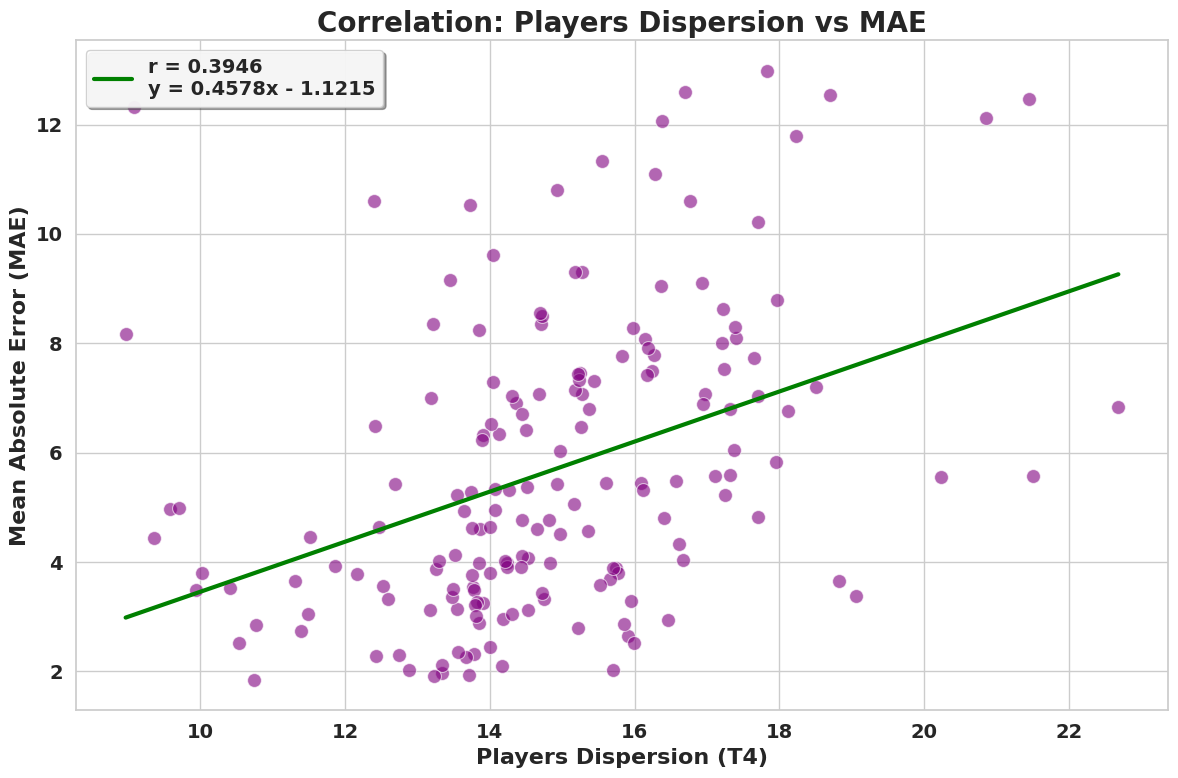

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Load the New Data
# Ensure the file name matches exactly
file_name = 'MAE_France_Dispersion.csv'
df = pd.read_csv(file_name)

# 2. Calculate Correlation and Line Equation
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df['Players_dispersion_T4'],
    df['MAE']
)

# Format the equation string
sign = '+' if intercept >= 0 else '-'
line_eq = f"y = {slope:.4f}x {sign} {abs(intercept):.4f}"
corr_text = f"r = {r_value:.4f}"
legend_text = f"{corr_text}\n{line_eq}"

# 3. Professional Styling
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

plt.figure(figsize=(12, 8))

# 4. Plotting with NEW COLORS
# Scatter points in Purple
sns.scatterplot(
    data=df,
    x='Players_dispersion_T4',
    y='MAE',
    s=100,
    alpha=0.6,
    color='purple',   # <--- Changed color for points
    edgecolor='white'
)

# 5. Add the Regression Line in Green
x_range = np.linspace(
    df['Players_dispersion_T4'].min(),
    df['Players_dispersion_T4'].max(),
    100
)
y_range = slope * x_range + intercept

plt.plot(
    x_range,
    y_range,
    color='green',    # <--- Changed color for line
    linewidth=3,
    label=legend_text
)

# 6. Final Polish
plt.legend(
    loc='best',
    frameon=True,
    shadow=True,
    facecolor='white',
    framealpha=0.9
)

plt.title('Correlation: Players Dispersion vs MAE')
plt.xlabel('Players Dispersion (T4)')
plt.ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()

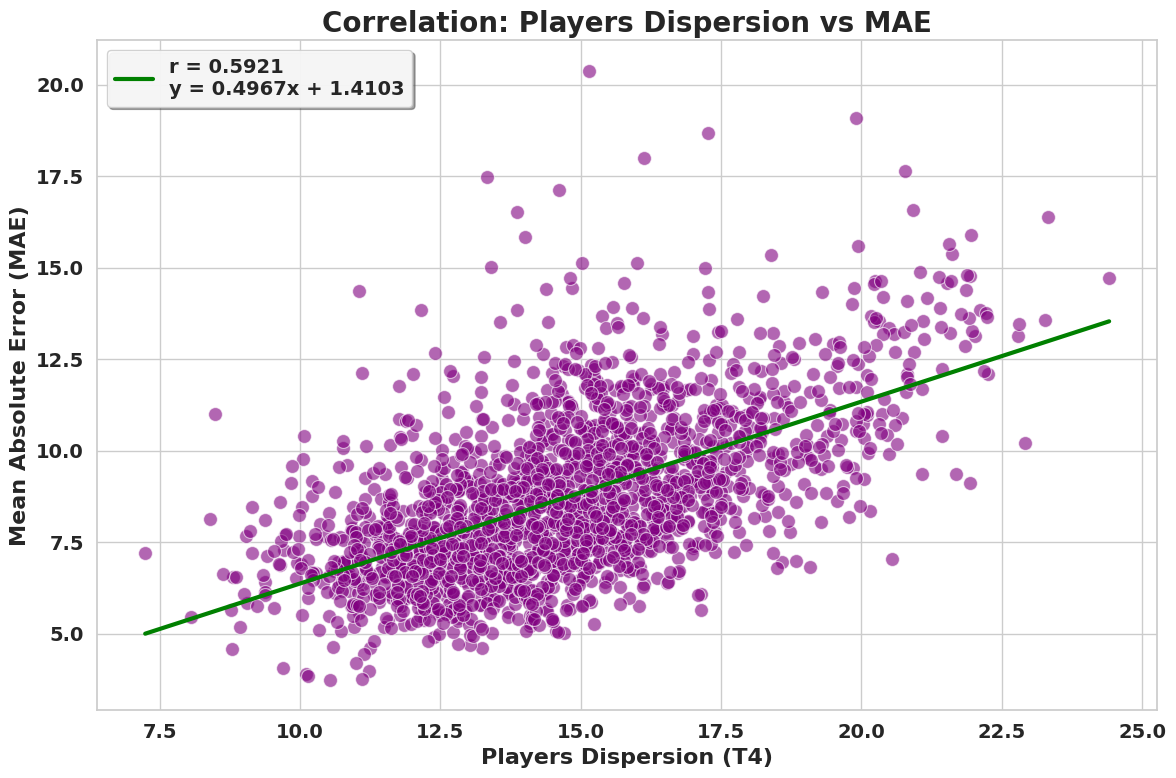

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Load the Data
# Ensure the file name matches exactly what you have in Colab
file_name = 'MAE_Baseline_France_Dispersion.csv'
df = pd.read_csv(file_name)

# 2. Calculate Correlation and Line Equation
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df['Players_dispersion_T4'],
    df['MAE']
)

# Format the equation string
sign = '+' if intercept >= 0 else '-'
line_eq = f"y = {slope:.4f}x {sign} {abs(intercept):.4f}"
corr_text = f"r = {r_value:.4f}"
legend_text = f"{corr_text}\n{line_eq}"

# 3. Professional Styling
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

plt.figure(figsize=(12, 8))

# 4. Plotting with NEW COLORS
# Scatter points in Purple
sns.scatterplot(
    data=df,
    x='Players_dispersion_T4',
    y='MAE',
    s=100,
    alpha=0.6,
    color='purple',
    edgecolor='white'
)

# 5. Add the Regression Line in Green
x_range = np.linspace(
    df['Players_dispersion_T4'].min(),
    df['Players_dispersion_T4'].max(),
    100
)
y_range = slope * x_range + intercept

plt.plot(
    x_range,
    y_range,
    color='green',
    linewidth=3,
    label=legend_text
)

# 6. Final Polish
plt.legend(
    loc='upper left',     # <--- Changed this from 'best' to 'upper left'
    frameon=True,
    shadow=True,
    facecolor='white',
    framealpha=0.9
)

plt.title('Correlation: Players Dispersion vs MAE')
plt.xlabel('Players Dispersion (T4)')
plt.ylabel('Mean Absolute Error (MAE)')

plt.tight_layout()
plt.show()